In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.tensor_module, modules.bullets

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
from modules.tensor_module import *
from modules.bullets import *
import copy

# Tensors
import tntorch as tn
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac, partial_tucker
from tensorly.tenalg import mode_dot, multi_mode_dot


# ML
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

import xgboost as xgb
import pystmm


import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import parallel_backend


## Load initial ds_dict

In [3]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



In [4]:
df = ds_dict['G101__trial1__left__call']['skeleton']
df.head(5)

pose__0__x  pose__0__y  pose__0__z  pose__1__x  pose__1__y  pose__1__z  \
0    0.504566    0.483007   -0.419187    0.512195    0.468248   -0.393816   
1    0.505714    0.482927   -0.419194    0.512769    0.468184   -0.393802   
2    0.506588    0.482852   -0.431591    0.513260    0.468151   -0.406269   
3    0.507106    0.482764   -0.430026    0.513574    0.468106   -0.404846   
4    0.507399    0.482719   -0.437200    0.513772    0.468082   -0.412200   

   pose__2__x  pose__2__y  pose__2__z  pose__3__x  ...  right_hand__17__z  \
0    0.517451    0.468759   -0.394230    0.523402  ...           0.001779   
1    0.518419    0.468713   -0.394216    0.524386  ...           0.001621   
2    0.519245    0.468693   -0.406685    0.525111  ...           0.001963   
3    0.519717    0.468653   -0.405261    0.525549  ...           0.002475   
4    0.519957    0.468635   -0.412618    0.525805  ...           0.002163   

   right_hand__18__x  right_hand__18__y  right_hand__18__z  right_hand__19__x  \
0           0.419982           0.874274           0.001036           0.426798   
1           0.420453           0.875529           0.001330           0.427345   
2           0.419988           0.874982           0.001869           0.426918   
3           0.419770           0.874797           0.002538           0.426700   
4           0.419992           0.875094           0.002145           0.426787   

   right_hand__19__y  right_hand__19__z  right_hand__20__x  right_hand__20__y  \
0           0.878431           0.001724           0.431595           0.878332   
1           0.879538           0.002506           0.432357           0.879545   
2           0.879153           0.003044           0.432110           0.879536   
3           0.878337           0.003782           0.431636           0.878009   
4           0.878402           0.003366           0.431563           0.877772   

   right_hand__20__z  
0           0.002642  
1           0.003786  
2           0.004282  
3           0.005091  
4           0.004613  

[5 rows x 324 columns]

In [5]:
ds_dict['G101__trial1__left__call'].keys()

dict_keys(['skeleton', 'info', '_start_end_'])

## Selecting 

In [6]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
# gestures += ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures += ['screenshot', 'writing', 'delete']
# gestures += ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures += ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gestures += ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gestures += ['yes_head', 'no_head']

In [7]:
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5]"
# exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] 3,4D"

exp_cofig = "one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test"

# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[5:], test: subs[:5]"
# exp_cofig = "all gestures  | [x, y] | fill_na: {'value':0} | train: subs[:], test: subs[:5]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalid. Remain 2798(2812)


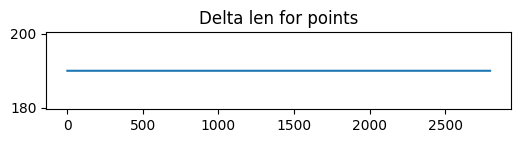

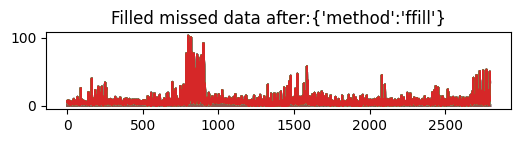

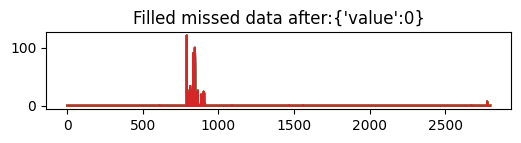

In [8]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
# gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samples(data_dict_selected)

# points
# data_dict_points = select_points(data_dict_valid, coords=['x', 'y'], hand_points=[])
data_dict_points = select_points(data_dict_valid, coords=['x', 'y'], hand_points='def')
plt.show()

# nan
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
data_dict_filled_ = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'method':'ffill'}}")
plt.show()

data_dict_filled = update_skeleton(data_dict_filled_, update_df_fill_na, {'value':0})
# data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'method':'ffill'})
plt.title(f"Filled missed data after:{{'value':0}}")
plt.show()

# # data_dict_filled = data_dict_points

del data_dict_filled_, data_dict_points, data_dict_valid, data_dict_selected


In [9]:
# cropping
data_dict_adjusted = data_dict_filled
data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_crop_time, show=False)

# additional preprocessing
# data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_to_speed, show=True)
# data_dict_adjusted = update_skeleton(data_dict_adjusted, update_df_to_coord_and_speed, show=True)





# #train
# print('Train')
# data_dict = select_g_ids(data_dict_adjusted, subs=subs[5:])
# data_dict, label_dict = form_gesture_labels(data_dict)
# samples_list,  labels_list = form_samples_labels_lists(data_dict)
# data_tensor = np.concatenate(samples_list, axis=0)

# #test 
# print('Test')
# data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
# data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
# samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
# data_tensor_test = np.concatenate(samples_list_test, axis=0)

#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[5:])
data_dict, label_dict = form_gesture_labels(data_dict, label_dict=None)
samples_list,  labels_list, se_list = form_samples_labels_se_lists(data_dict)
data_tensor = np.concatenate(samples_list, axis=0)
se_tensor = form_se_tensor(se_list, data_tensor.shape[1])

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[:5])
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test, label_dict=label_dict)
samples_list_test,  labels_list_test, se_list_test = form_samples_labels_se_lists(data_dict_test)
data_tensor_test = np.concatenate(samples_list_test, axis=0)
se_tensor_test = form_se_tensor(se_list_test, data_tensor_test.shape[1])

Train
Selected  2141 samples. 657(2798) was dropped!
Test
Selected  657 samples. 2141(2798) was dropped!


## Alignment

In [10]:
# Alignment functions

def align_tensor_by_start(tensor, se_array, new_start=10,  tail='roll', t_dim=1):
    good_tail = ['roll', 'last']
    assert tail in good_tail, f"Error! tail = {tail}, but it should be in {good_tail}"
    tensor = tensor.copy()
    
    for i in range(tensor.shape[0]):
        data = tensor[i]
        s = int(np.round(se_array[i][0], 0))
        shift = np.max([-s + new_start, -s])
        data = np.roll(data, shift, axis=t_dim-1)
        if tail == 'last':
            data[shift:] = data[shift-1]
        tensor[i]= data
        
    return tensor

def align_tensor_by_end(tensor, se_array, new_end=10,  tail='roll', t_dim=1):
    good_tail = ['roll', 'first']
    assert tail in good_tail, f"Error! tail = {tail}, but it should be in {good_tail}"
    tensor = tensor.copy()
    t_size = tensor.shape[t_dim]
    for i in range(tensor.shape[0]):
        data = tensor[i]
        e = int(np.round(se_array[i][1], 0))
        shift = np.min([new_end - e, t_size - e])
        data = np.roll(data, shift, axis=t_dim-1)
        if tail == 'first':
            data[:shift] = data[shift]
        tensor[i]= data
        
    return tensor


def align_tensor_by_se(tensor_data, se_list, s_e_new=[5, 65], filling='fl'):
    
    good_fillings = ['fl', 'first/last', 'roll']
    assert filling in good_fillings, f"Error! filling={filling} should be in {good_fillings}!"
    
    f_tensor = tensor_data.copy()
    samples, duration, signals = f_tensor.shape
    
    s_e_new = np.asarray(s_e_new).reshape(-1, 2)
    
    if s_e_new.shape[0] == 1:
        s_e_new = np.repeat(s_e_new, samples, axis=0)
    elif s_e_new.shape[0] == samples:
        pass
    else:
        assert 0, f"Error, s_e_new.shape={s_e_new.shape} in np.array from"\
                  f" should have 1 or {samples} size of the first dimension"\
                  f"for given 'tensor_data'[{tensor_data.shape}]"
    
    print(s_e_new.shape)
    se_array = np.asarray(se_list)
    t = np.arange(0, duration)
    t_tensor = np.repeat(t.reshape(1, -1), samples, axis=0)
    
    
    k_stretching =  (s_e_new [:,1:2] - s_e_new [:,0:1])/(se_array[:,1:2] - se_array[:,0:1])   
    t_tensor_  = (t_tensor -  se_array[:, 0:1])*k_stretching + s_e_new[:,0:1]
    
    
    # Skipping the null procedures
    mask = (np.round(s_e_new,0) == np.round(se_array,0)).prod(axis=1).astype(bool)
    # print(mask)
    t_tensor_[mask] = t_tensor[mask]
    print(f"{mask.sum()} procedures (from {mask.size}) were skipped!")
    
    t_tensor = t_tensor_
    
    interp_period = None
    if filling in ['fl', 'first/last']:
        interp_period = None
    elif filling in ['roll']:
        interp_period = duration
    else:
        print(f"Warning! activity for 'filling'={filling} is not defined! Default: interp_period=None!!")
        
    
    
    for k in range(signals):
        for i in range(samples):
            f = f_tensor[i, :, k]
            t = t_tensor[i, :]
            f_new = np.interp(np.arange(0, duration),t, f, period=interp_period)
            f_tensor[i, :, k] = f_new
            
    return f_tensor

def gen_random_SE(samples, duration, deltas_arr, distrib='uniform', a=None, b=None, strict_border=True):
    good_distrib = ['uniform', 'u', 'normal', 'norm' , 'n']
    assert distrib in good_distrib, f"Error! distrib={distrib} should be one of {good_distrib}"
    
    if len(deltas_arr.shape) < 2:
        deltas_arr = np.expand_dims(deltas_arr, 1)
        
    
    start_arr = None
    if distrib in ['uniform', 'u']:
        start_arr = np.random.randint(a, b+1, size=[samples,1])
    elif distrib in ['normal', 'norm' , 'n']:
        start_arr = np.random.normal(a, b, size=[samples,1])
        start_arr = np.around(start_arr, 0)
    else:
        start_arr = None
        
    if strict_border:
        start_arr[start_arr < 0] = 0
        
    end_arr =  start_arr +  deltas_arr
    if strict_border: 
        mask = end_arr >= duration
        end_arr[mask] = duration
        start_arr[mask] = duration - deltas_arr[mask]
        
    return np.concatenate([start_arr, end_arr], axis=1)


### SE augmentation testing

In [16]:
se_arr = np.asarray(se_list)
deltas = se_arr[:,1] -  se_arr[:,0]
s_e_uniform = gen_random_SE(2141, 120, deltas, distrib='uniform', a=0, b=120, strict_border=False )
s_e_norm = gen_random_SE(2141, 120, deltas, distrib='norm', a=60, b=30, strict_border=False )

In [19]:
se_ = s_e_uniform
print('Max:', se_.max(axis=0), ' delta:', (se_[:,1] - se_[:,0]).max())
print('Mean:', se_.mean(axis=0), ' delta:', (se_[:,1] - se_[:,0]).mean())
print('Min:', se_.min(axis=0), ' delta:', (se_[:,1] - se_[:,0]).min())
print('Min:', se_.std(axis=0), ' delta:', (se_[:,1] - se_[:,0]).std())

Max: [120. 212.]  delta: 98.0
Mean: [ 60.55768333 120.49602989]  delta: 59.93834656702475
Min: [ 0. 39.]  delta: 28.0
Min: [35.26478295 36.60393835]  delta: 10.764557325641565


(array([202., 223., 209., 203., 226., 206., 204., 195., 226., 247.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <BarContainer object of 10 artists>)

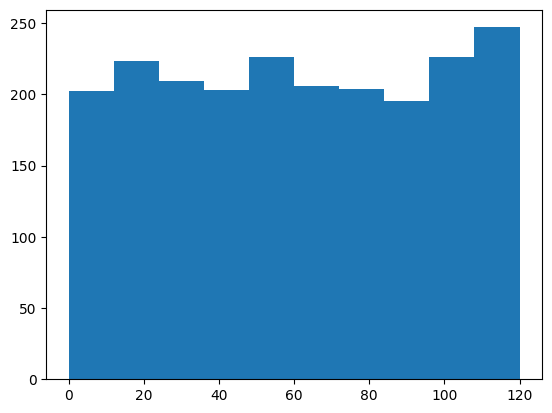

In [21]:
plt.hist(s_e_uniform[:,0])

### SE investigation

In [24]:
se_all = np.concatenate([np.asarray(se_list),np.asarray(se_list_test),], axis=0) 

In [25]:
se_ = se_all
print('Max:', se_.max(axis=0), ' delta:', (se_[:,1] - se_[:,0]).max())
print('Mean:', se_.mean(axis=0), ' delta:', (se_[:,1] - se_[:,0]).mean())
print('Min:', se_.min(axis=0), ' delta:', (se_[:,1] - se_[:,0]).min())
print('Min:', se_.std(axis=0), ' delta:', (se_[:,1] - se_[:,0]).std())

Max: [ 41. 119.]  delta: 108.0
Mean: [17.50321658 77.57576841]  delta: 60.072551822730524
Min: [ 9. 45.]  delta: 28.0
Min: [ 3.50825999 10.53031698]  delta: 11.013350011575898


Text(0.5, 1.0, 'Stop')

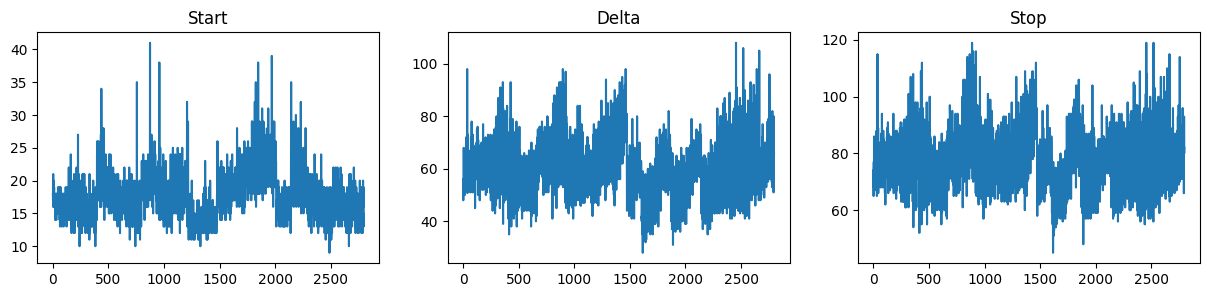

In [26]:
plt.figure(figsize=[15, 3])
ax = plt.subplot(131,)
ax.plot(se_all[:,0])
ax.set_title('Start')
ax = plt.subplot(132)
ax.plot(se_all[:,1] - se_all[:,0])
ax.set_title('Delta')
ax = plt.subplot(133)
ax.plot(se_all[:,1])
ax.set_title('Stop')

Text(0.5, 1.0, 'Stop')

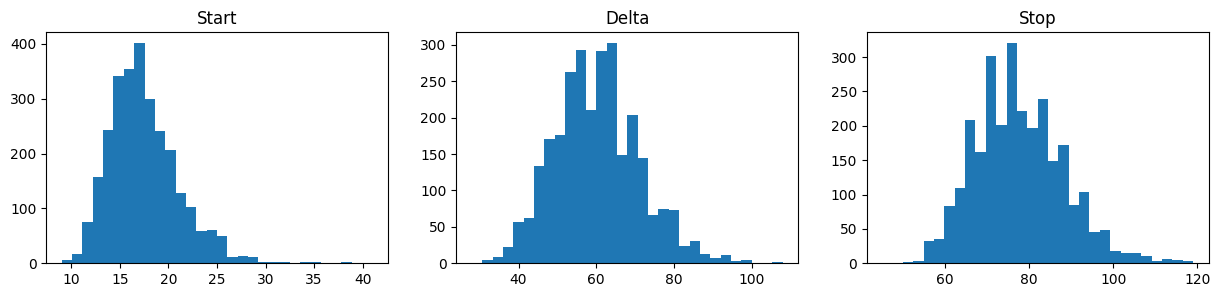

In [53]:
plt.figure(figsize=[15, 3])
ax = plt.subplot(131,)
ax.hist(se_all[:,0], bins=30)
ax.set_title('Start')
ax = plt.subplot(132)
ax.hist(se_all[:,1] - se_all[:,0], bins=30)
ax.set_title('Delta')
ax = plt.subplot(133)
ax.hist(se_all[:,1], bins=30)
ax.set_title('Stop')

### Alignment

In [27]:
# S, E, SE alignment

data_tensor_align_s = align_tensor_by_start(data_tensor, se_list, new_start=5, tail='last')
data_tensor_test_align_s = align_tensor_by_start(data_tensor_test, se_list_test, new_start=5, tail='last')

data_tensor_align_e = align_tensor_by_end(data_tensor, se_list, new_end=100, tail='first')
data_tensor_test_align_e = align_tensor_by_end(data_tensor_test, se_list_test, new_end=100, tail='first')


# data_tensor_align_s = align_tensor_by_start(data_tensor, se_list, new_start=5, tail='roll')
# data_tensor_test_align_s = align_tensor_by_start(data_tensor_test, se_list_test, new_start=5, tail='roll')

# data_tensor_align_e = align_tensor_by_end(data_tensor, se_list, new_end=100, tail='roll')
# data_tensor_test_align_e = align_tensor_by_end(data_tensor_test, se_list_test, new_end=100, tail='roll')

data_tensor_align_se = align_tensor_by_se(data_tensor, se_list, s_e_new=[5, 65])
data_tensor_test_align_se = align_tensor_by_se(data_tensor_test, se_list_test, s_e_new=[5, 65])


# augmentation normal
# normal
deltas = np.asarray(se_list)[:,1] - np.asarray(se_list)[:,0]
deltas_test = np.asarray(se_list_test)[:,1] - np.asarray(se_list_test)[:,0] 

s_e_uniform = gen_random_SE(*data_tensor.shape[:2], deltas, distrib='uniform', a=5, b=45, strict_border=True)
s_e_uniform_test  = gen_random_SE(*data_tensor_test.shape[:2], deltas_test, distrib='uniform', a=5, b=45, strict_border=True )
data_tensor_aug_u = align_tensor_by_se(data_tensor, se_list, s_e_new=s_e_uniform, filling='first/last')
data_tensor_test_aug_u = align_tensor_by_se(data_tensor_test, se_list_test, s_e_new=s_e_uniform_test, filling='first/last')

s_e_norm = gen_random_SE(*data_tensor.shape[:2], deltas, distrib='norm', a=25, b=6, strict_border=True )
s_e_norm_test  = gen_random_SE(*data_tensor_test.shape[:2], deltas_test, distrib='norm', a=25, b=10, strict_border=True )
data_tensor_aug_n = align_tensor_by_se(data_tensor, se_list, s_e_new=s_e_norm, filling='first/last')
data_tensor_test_aug_n = align_tensor_by_se(data_tensor_test, se_list_test, s_e_new=s_e_norm_test, filling='first/last')

# hard
s_e_uniform_h = gen_random_SE(*data_tensor.shape[:2], deltas, distrib='uniform', a=0, b=120, strict_border=False)
s_e_uniform_test_h  = gen_random_SE(*data_tensor_test.shape[:2], deltas_test, distrib='uniform', a=0, b=120, strict_border=False )
data_tensor_aug_u_h = align_tensor_by_se(data_tensor, se_list, s_e_new=s_e_uniform_h, filling='roll')
data_tensor_test_aug_u_h = align_tensor_by_se(data_tensor_test, se_list_test, s_e_new=s_e_uniform_test_h, filling='roll')

s_e_norm_h = gen_random_SE(*data_tensor.shape[:2], deltas, distrib='norm', a=60, b=30, strict_border=False )
s_e_norm_test_h  = gen_random_SE(*data_tensor_test.shape[:2], deltas_test, distrib='norm', a=60, b=30, strict_border=False )
data_tensor_aug_n_h = align_tensor_by_se(data_tensor, se_list, s_e_new=s_e_norm_h, filling='roll')
data_tensor_test_aug_n_h = align_tensor_by_se(data_tensor_test, se_list_test, s_e_new=s_e_norm_test_h, filling='roll')



(2141, 2)
0 procedures (from 2141) were skipped!
(657, 2)
0 procedures (from 657) were skipped!
(2141, 2)
54 procedures (from 2141) were skipped!
(657, 2)
14 procedures (from 657) were skipped!
(2141, 2)
70 procedures (from 2141) were skipped!
(657, 2)
18 procedures (from 657) were skipped!
(2141, 2)
21 procedures (from 2141) were skipped!
(657, 2)
9 procedures (from 657) were skipped!
(2141, 2)
18 procedures (from 2141) were skipped!
(657, 2)
0 procedures (from 657) were skipped!


#### Alignment checking

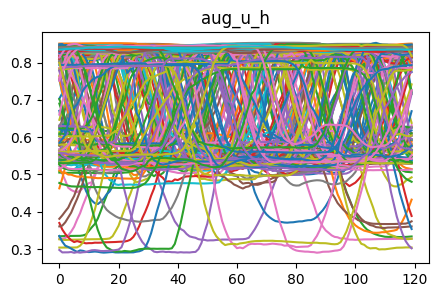

In [93]:
plt.plot(data_tensor_aug_u_h[300:700, :, 15*2+1].T)
plt.gcf().set_size_inches(5, 3)
plt.title('aug_u_h')
plt.show()

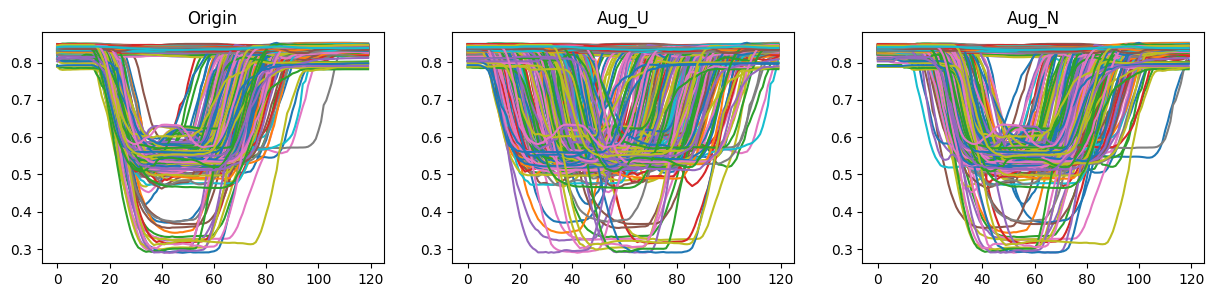

In [178]:
plt.figure(figsize=[15, 3])
ax = plt.subplot(131,)
plt.plot(data_tensor[300:700, :, 15*2+1].T)
ax.set_title('Origin')
ax = plt.subplot(132)
plt.plot(data_tensor_aug_u[300:700, :, 15*2+1].T)
ax.set_title('Aug_U')
ax = plt.subplot(133)
plt.plot(data_tensor_aug_n[300:700, :, 15*2+1].T)
ax.set_title('Aug_N')
plt.show()

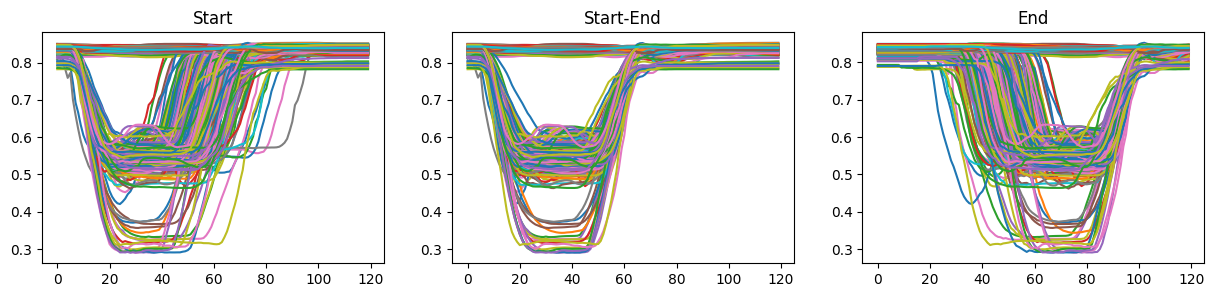

In [30]:
plt.figure(figsize=[15, 3])
ax = plt.subplot(131,)
plt.plot(data_tensor_align_s[300:700, :, 15*2+1].T)
ax.set_title('Start')
ax = plt.subplot(132)
plt.plot(data_tensor_align_se[300:700, :, 15*2+1].T)
ax.set_title('Start-End')
ax = plt.subplot(133)
plt.plot(data_tensor_align_e[300:700, :, 15*2+1].T)
ax.set_title('End')
plt.show()


## Tensor preprocessing

### Tucker

#### reshaping

In [ ]:
# tensor_tucker, tensor_tucker_test = get_tucker_tensors(data_tensor, data_tensor_test)

In [198]:
# def do_reshaping(tensor):
#     tensor = tensor.reshape(tensor.shape[:2] + (-1, 2))
#     tensor = tensor.transpose([0, 1, 3, 2])
#     tensor = tensor.reshape(tensor.shape[:3] + (-1,tensor.shape[-1]//2,))
#     tensor = tensor.transpose([0, 1, 4, 3, 2])
#     return tensor

# def do_reshaping(tensor):
#     tensor = tensor.reshape(tensor.shape[:2] + (-1, 2))
#     tensor = tensor.transpose([0, 1, 3, 2])
#     tensor = tensor.reshape(tensor.shape[:3] + (-1,tensor.shape[-1]//2,))
#     tensor = tensor.transpose([0, 1, 4, 3, 2])  # [X Y Vx Vy]
#     # tensor = tensor.transpose([0, 1, 4, 2, 3])  # [X Vx Y Vy] 
#     # tensor = np.concatenate([tensor[:,:,:,:,0] , tensor[:,:,:,:,1]], axis=-1)


#     tensor = tensor.reshape(tensor.shape[:3] + (-1,))
#     return tensor

In [21]:
# data_tensor_ = data_tensor.reshape(data_tensor.shape[:2] + (-1, 2))
# data_tensor_test_ = data_tensor_test.reshape(data_tensor_test.shape[:2] + (-1, 2))

# data_tensor_ = do_reshaping(data_tensor)
# data_tensor_test_ = do_reshaping(data_tensor_test)

NameError: name 'do_reshaping' is not defined

In [191]:
# tensor = data_tensor
# tensor = tensor.reshape(tensor.shape[:2] + (-1, 2))
# tensor = tensor.transpose([0, 1, 3, 2])
# tensor = tensor.reshape(tensor.shape[:3] + (-1,tensor.shape[-1]//2,))
# # tensor = tensor.transpose([0, 1, 4, 3, 2])  # [X Vx Y Vy]
# tensor = tensor.transpose([0, 1, 4, 2, 3]) # [X Y Vx Vy]
# # tensor = np.concatenate([tensor[:,:,:,:,0] , tensor[:,:,:,:,1]], axis=-1)


# tensor = tensor.reshape(tensor.shape[:3] + (-1,))

In [108]:
# tensor.shape
# data_tensor_ = tensor

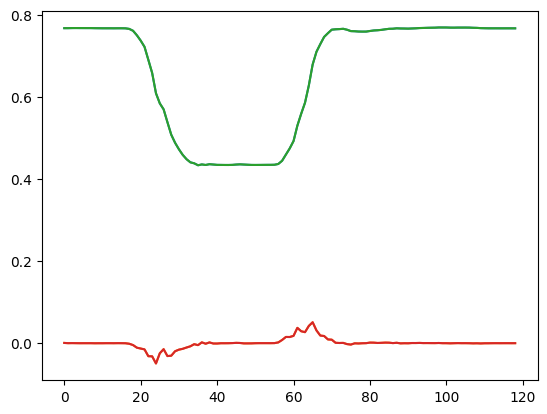

In [202]:
l = 15*2+1
plt.plot(data_tensor[10, :, l])
plt.plot(data_tensor[10, :, l+134])

# # for 4D (a)
# plt.plot(data_tensor_[10, :,15, 1])
# plt.plot(data_tensor_[10, :,67+15, 1,])

# for 4D (b)
# plt.plot(data_tensor_[10, :,15, 2])
# plt.plot(data_tensor_[10, :,15, 3])
plt.plot(data_tensor_[10, :,15, 1])
plt.plot(data_tensor_[10, :,15, 3])


# # for 5D
# plt.plot(data_tensor_[10, :,15, 0, 1])
# plt.plot(data_tensor_[10, :,15, 1, 1])

#### Tensor transformation

In [51]:
tensor_tucker, tensor_tucker_test = get_tucker_tensors_tn(data_tensor, data_tensor_test)
print("For data_tensor ---> done!")
print()

tensor_tucker_align_s, tensor_tucker_test_align_s = get_tucker_tensors_tn(data_tensor_align_s, data_tensor_test_align_s)
print("For data_tensor_align_s ---> done!")
tensor_tucker_align_se, tensor_tucker_test_align_se = get_tucker_tensors_tn(data_tensor_align_se, data_tensor_test_align_se)
print("For data_tensor_align_se ---> done!")
tensor_tucker_align_e, tensor_tucker_test_align_e = get_tucker_tensors_tn(data_tensor_align_e, data_tensor_test_align_e)
print("For data_tensor_align_e ---> done!")
print()

tensor_tucker_aug_u, tensor_tucker_test_aug_u = get_tucker_tensors_tn(data_tensor_aug_u, data_tensor_test_aug_u)
print("For data_tensor_aug_u ---> done!")
tensor_tucker_aug_n, tensor_tucker_test_aug_n = get_tucker_tensors_tn(data_tensor_aug_n, data_tensor_test_aug_n)
print("For data_tensor_aug_n ---> done!")

tensor_tucker_aug_u_h, tensor_tucker_test_aug_u_h = get_tucker_tensors_tn(data_tensor_aug_u_h, data_tensor_test_aug_u_h)
print("For data_tensor_aug_u_h ---> done!")

tensor_tucker_aug_n_h, tensor_tucker_test_aug_n_h = get_tucker_tensors_tn(data_tensor_aug_n_h, data_tensor_test_aug_n_h)
print("For data_tensor_aug_n_h ---> done!")








Tucker decomposition with rank: (2141, 120, 134). tensor shape: (2141, 120, 134)
Tucker: Rank: (2141, 120, 134), rel_error:  0.00000 ; norm origin: 3748.6873156097404 ; norm recovered: 3748.697509765625
For data_tensor ---> done!

Tucker decomposition with rank: (2141, 120, 134). tensor shape: (2141, 120, 134)
Tucker: Rank: (2141, 120, 134), rel_error:  0.00000 ; norm origin: 3749.5695709349047 ; norm recovered: 3749.5791015625
For data_tensor_align_s ---> done!
Tucker decomposition with rank: (2141, 120, 134). tensor shape: (2141, 120, 134)
Tucker: Rank: (2141, 120, 134), rel_error:  0.00000 ; norm origin: 3750.59829807856 ; norm recovered: 3750.613525390625
For data_tensor_align_se ---> done!
Tucker decomposition with rank: (2141, 120, 134). tensor shape: (2141, 120, 134)
Tucker: Rank: (2141, 120, 134), rel_error:  0.00000 ; norm origin: 3752.8638489006707 ; norm recovered: 3752.868896484375
For data_tensor_align_e ---> done!

Tucker decomposition with rank: (2141, 120, 134). tensor 

### ML Cross validation 

In [181]:
def do_cross_validation_per_subs(data_dict_adjusted, model_pair, decompose=None, decompose_rank=-1,  n_trials=10, subs=-1, pref='',  step=5,):
    if subs == -1:
        subs = get_all_subs_from_ds_dict(data_dict_adjusted)
        
    acc_list = []
    for i, cv_block in enumerate(split_cross_validation(data_dict_adjusted, subs, step=step)):
        data_tensor, data_tensor_test, labels_list, labels_list_test = cv_block
        
        
        print(f"Decomposition {decompose} with rank {decompose_rank}:", end='   ')
        if decompose is None:
            decompose = 'none'
            
        decompose = decompose.lower()
            
        if decompose in ['none', '-']:
            tensor = data_tensor
            tensor_test = data_tensor_test
        elif decompose in ['tucker']:
                tensor, tensor_test = get_tucker_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        elif decompose in ['svd']:
            tensor, tensor_test = get_SVD_tensors(data_tensor, data_tensor_test, rank=decompose_rank, verbose=2)
        # print(" was done!")
            
        decompose_str = '' if decompose in ['none', '-'] else decompose + '+' 
        acc_trial_list = []
        print(f'Start testing model: {decompose_str + model_pair[1]}')
        for j in range(n_trials):
            print('j =', j, ': ', end='')
            acc = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref, verbose=0)
            print(acc)
            acc_trial_list += [acc]
        acc_trial_array = np.array(acc_trial_list)
        acc_mean = acc_trial_array.mean()
        acc_std = acc_trial_array.std(ddof=1)
        
        acc_list += [acc]
        print(f"Acc[{i}] = {100*acc_mean:2.2f}({100*acc_std:2.2f})%")
        print()
    print()
    acc_array = np.array(acc_list)
    print(f"Cross validation with {i+1} blocks was ended.")
    print(f"Mean acc={100*acc_array.mean():2.2f}%")
    
    return acc_list
    
    
    
    

In [15]:
model_pair = (RandomForestClassifier(n_estimators=1, max_depth=2, n_jobs=-1), 'RandForest')
ass_array = do_cross_validation_per_subs(data_dict_adjusted, model_pair, 'Tucker', pref='', decompose_rank=[8,8], step=7,)


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']
Selected  4986 samples. 2482(7468) was dropped!
Selected  2482 samples. 4986(7468) was dropped!
Decomposition Tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4986, 120, 134)
Tucker: Rank: [8, 8], rel_error:  0.11315 ; norm origin: 5613.683332579163 ; norm recovered: 5577.633769428874
Start testing model: tucker+RandForest
j = 0 : 0.08259468170829976
j = 1 : 0.1031426269137792
j = 2 : 0.09669621273166801
j = 3 : 0.06365834004834811
j = 4 : 0.088638195004029
j = 5 : 0.09830781627719581
j = 6 : 0.0854149879129734
j = 7 : 0.05922643029814666
j = 8 : 0.08259468170829976
j = 9 : 0.0684931506849315
Acc[0] = 8.29(1.50)%


For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']
Selected  4960 samples. 2508(7468) was dropped!
Selected  2508 samples. 4960(7468) was dropped!
Decomposition tucker with rank [8, 8]:   Decomposition with rank: [8, 8]. tensor shape: (4960, 120, 13

In [111]:
cv_list = [cv for cv in split_cross_validation(data_dict_adjusted, subs, step=7)]


For test subjects: ['G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107']

For test subjects: ['G108', 'G109', 'G110', 'G111', 'G112', 'G113', 'G114']

For test subjects: ['G115', 'G116', 'G117', 'G118', 'G119', 'G120', 'G121']


In [ ]:


def split_cross_validation(data_dict_adjusted, subs, step=5):
    
    end = len(subs) - step
    if len(subs) % step == 0:
        end +=1
            
    cv_list = []

    for i, start in enumerate([ii for ii in range(0, end, step)]):
        
        test_subs = [sub for sub in subs[start:start+step]]
        train_subs = [sub for sub in subs if sub not in test_subs]
        print(f"\nFor test subjects: {test_subs}")
        
        # train
        data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
        data_dict, label_dict = form_gesture_labels(data_dict)
        samples_list,  labels_list = form_samples_labels_lists(data_dict)
        data_tensor = np.concatenate(samples_list, axis=0)

        #test 
        data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
        data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
        samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
        data_tensor_test = np.concatenate(samples_list_test, axis=0)
        
        
        yield [data_tensor, data_tensor_test, labels_list, labels_list_test]

        
        
    #     cv_list += [[data_tensor, data_tensor_test, labels_list, labels_list_test]]
    
    # return cv_list



# def corss_validation(data_dict_adjusted, subs, step=5, origin_models_pair=[], tensor_models_pair=[]):
#     #train
    
#     n_cross = (len(subs) - step) // step
#     origin_acc_tensor = np.zeros((len(origin_models_pair), n_cross))
#     tensor_acc_tensor = np.zeros((len(tensor_models_pair), n_cross))

#     for i, start in enumerate([ii for ii in range(0, len(subs) - step, step)]):
#         print(f"For stest subjects: {test_subs}")
#         test_subs = [sub for sub in subs[start, start+step]]
#         train_subs = [sub for sub in subs if sub not in test_subs]
        
#         # train
#         data_dict = select_g_ids(data_dict_adjusted, subs=train_subs)
#         data_dict, label_dict = form_gesture_labels(data_dict)
#         samples_list,  labels_list = form_samples_labels_lists(data_dict)
#         tensor = np.concatenate(samples_list, axis=0)

#         #test 
#         data_dict_test = select_g_ids(data_dict_adjusted, subs=test_subs)
#         data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
#         samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
#         tensor_test = np.concatenate(samples_list_test, axis=0)
        
#         print('Test and train was splited')
        
        
#         # tucker
#         t = tensor
#         tt = tensor_test
#         rank = [120, 134]
#         core_tucker, factors_tucker = partial_tucker(t, [1, 2], rank=rank, n_iter_max=1000)
#         t_rec_tucker = tl.tucker_to_tensor((core_tucker, [None] + factors_tucker), skip_factor=0)
#         print(f"Tucker: Rank: {rank }, rel_error: {tl.norm(t - t_rec_tucker)/tl.norm(t): .5f} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")
        
        
#         factors = factors_tucker
#         factors = [None] + factors

#         tensor_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         tensor_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])
#         print('Tensors was decomposed')
        
#         #origin models:
        
#         print('For original data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: {model_name}, acc =", end = ' ' )
            
#             model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             origin_acc_tensor[j, i] = acc_test 
            
#         print('For tranformed data')
#         for j, model_pair in enumerate(origin_models_pair):
#             model, model_name = model_pair
#             print(f"   for model: tensor +{model_name }, acc =", end = ' ' )
            
#             tensor = tensor_tucker
#             tensor_test = tensor_tucker_test
            
#             X_train, y_train = make_X_y(tensor, labels_list)
#             X_test, y_test = make_X_y(tensor_test, labels_list_test)
            
#             if model_name in ['STMM', 'STM']:
#                 X_train = tensor
#                 X_test = tensor_test
#             else:
#                 X_train = StandardScaler().fit_transform(X_train)
#                 X_test = StandardScaler().fit_transform(X_test)

#             model.fit(X_train, y_train)
            
#             label_test = model.predict(X_test)
#             acc_test = accuracy_score(X_test, label_test)
#             print(acc_test)
#             tensor_acc_tensor[j, i] = acc_test
            
#         print()
#         print()
        
#     return origin_acc_tensor, tensor_acc_tensor
            
        

            
            
            
        
        
        

## Tensor components research

### Components plots

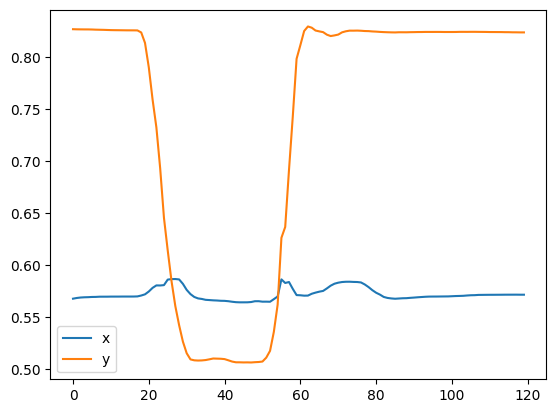

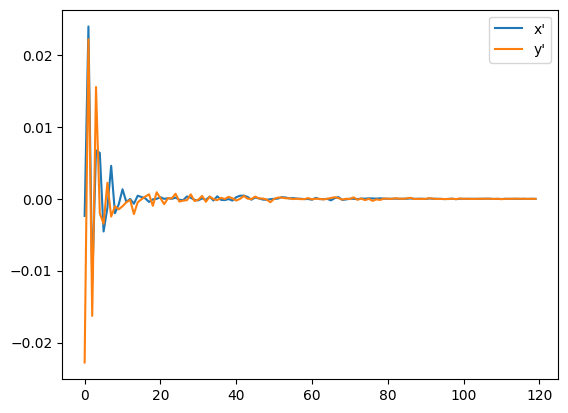

In [163]:
plt.plot(data_tensor_[0,:,15,:])
plt.legend(['x', 'y', 'z'])
# plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.show()

plt.plot(tensor_tucker_tn_[0,:,15,:])
# plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.legend(["x'", "y'", "z'"])
plt.show()

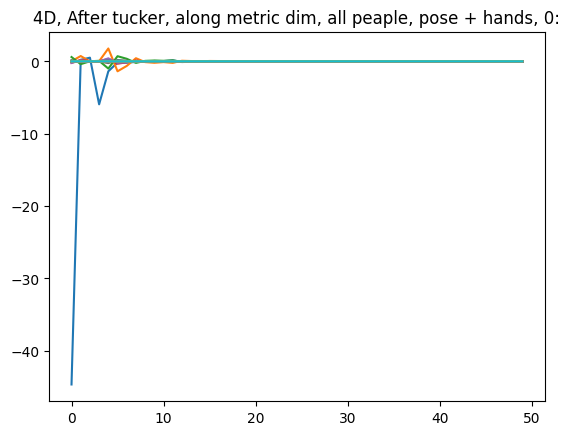

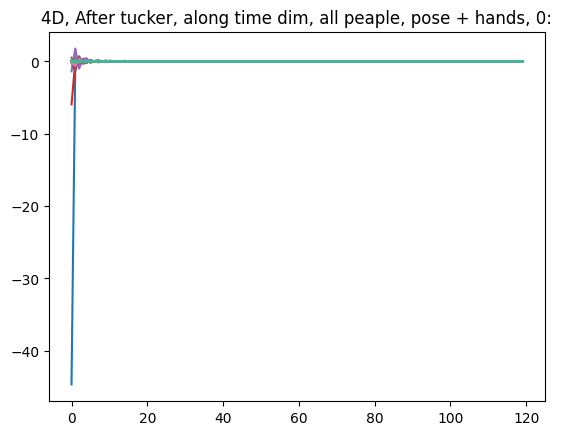

In [143]:
# 3D
# start_point = 1
# plt.plot(tensor_tucker_tn[0].T[:, start_point:])
# plt.title(f'After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
# plt.show()

# plt.plot(tensor_tucker_tn[0][:, start_point:])
# plt.title(f'After tucker, along time dim, all peaple, pose + hands, {start_point}:')
# plt.show()

# 4D
s1, s2 = tensor_tucker_tn.shape[:2]

start_point = 0
plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[0].T[:, start_point:])
plt.title(f'4D, After tucker, along metric dim, all peaple, pose + hands, {start_point}:')
plt.show()

plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[0][:, start_point:])
plt.title(f'4D, After tucker, along time dim, all peaple, pose + hands, {start_point}:')
plt.show()


### People indexes + component plot

In [144]:
# getting people indexes
s_list = []
for key in data_dict.keys():
    g_num = key[2:4]
    s_list += [int(g_num)]
    
s_array = np.array(s_list)
s_array = np.diff(s_array)
# plt.plot(s_array)
idx = np.where(s_array ==1)
    

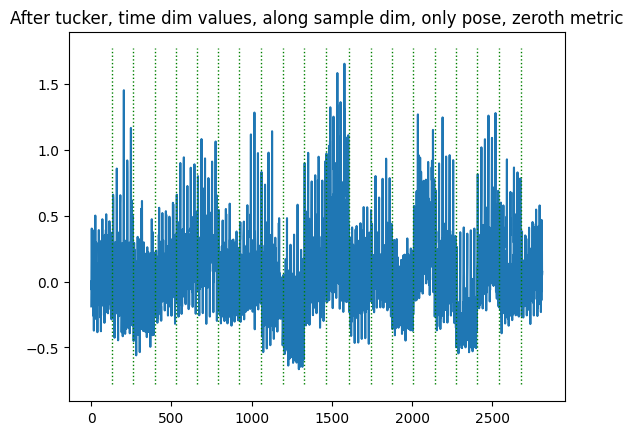

In [162]:
s1, s2 = tensor_tucker_tn.shape[:2]
# plt.plot(tensor_tucker_tn[:,0,0][:,0,12])
plt.plot(tensor_tucker_tn_.reshape([s1, s2, -1])[:,0,6])
ymin, ymax = plt.gca().get_ylim()
plt.vlines(x=idx, ymin=ymin, ymax=ymax, colors='green', ls=':', lw=1,)
plt.title('After tucker, time dim values, along sample dim, only pose, zeroth metric')
print()

### People feature data

In [160]:
# getting 21 point data
s1, s2 = tensor_tucker_tn.shape[:2]
# data = tensor_tucker_tn[:,0,0]
data = tensor_tucker_tn_.reshape([s1, s2 , -1])[:,0,5]
subs_data = []
idxs = [0] + list(idx[0]) + [len(data_dict.keys())]
for i in range(len(idxs) -1):
    subs_data += [np.mean(data[idxs[i]:idxs[i+1]])]
    

In [152]:
# saving 21 point data
# a = tensor_tucker_tn[:,0,0]
a = subs_data
with open('subs_data_mean_4D_to_3D__all_0_0_xy_pose.pkl', 'wb') as f:
    pickle.dump(a, f)

    

### Correlations between components

In [95]:
# findng correlations betseen components 
corr.iloc[10:25, 10:25]

10     11     12     13     14     15     16     17     18     19  \
10   True  False  False  False  False  False  False  False  False  False   
11  False   True  False  False   True  False  False  False  False  False   
12  False  False   True  False  False  False  False  False  False  False   
13  False  False  False   True   True  False  False  False  False  False   
14  False   True  False   True   True  False  False  False  False  False   
15  False  False  False  False  False   True  False  False  False  False   
16  False  False  False  False  False  False   True  False  False  False   
17  False  False  False  False  False  False  False   True  False  False   
18  False  False  False  False  False  False  False  False   True  False   
19  False  False  False  False  False  False  False  False  False   True   
20  False  False  False  False  False  False  False  False  False  False   
21  False  False  False  False  False  False  False  False  False  False   
22  False  False  False  False  False  False  False  False  False  False   
23  False  False  False  False  False  False  False  False  False  False   
24  False  False  False  False  False  False  False  False  False  False   

       20     21     22     23     24  
10  False  False  False  False  False  
11  False  False  False  False  False  
12  False  False  False  False  False  
13  False  False  False  False  False  
14  False  False  False  False  False  
15  False  False  False  False  False  
16  False  False  False  False  False  
17  False  False  False  False  False  
18  False  False  False  False  False  
19  False  False  False  False  False  
20   True  False  False  False  False  
21  False   True  False  False  False  
22  False  False   True  False  False  
23  False  False  False   True  False  
24  False  False  False  False   True

<AxesSubplot:>

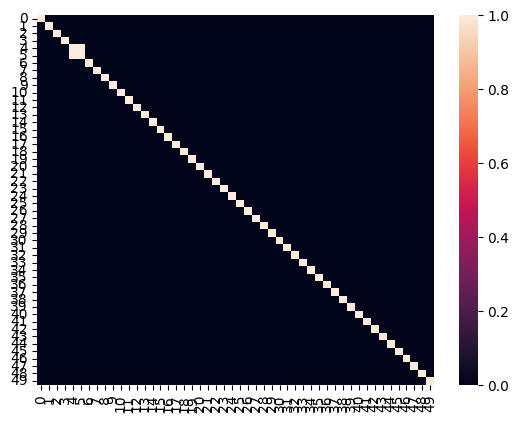

In [159]:
s1, s2 = tensor_tucker_tn.shape[:2]
df = pd.DataFrame(tensor_tucker_tn_.reshape([s1, s2, -1])[:,0,:])
# data = tensor_tucker_tn[:,0,0]
corr = df.corr().abs() > 0.9

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)



# ML part 

### code

In [52]:
def test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref='', verbose=1):
    model, model_name = model_pair
    if verbose:
        print(f'Model {pref + model_name} is fitting...')
    
    model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
    if verbose:
        print(f"   for model: {pref + model_name}, acc =", end = ' ' )
    label_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, label_test)
    if verbose:
        print(f"{acc_test: .4f}")
    return acc_test
    


def test_model_pair_list(model_pair_list, tensor, tensor_test, labels_list, labels_list_test, pref=''):
    acc_list = []
    for j, model_pair in enumerate(model_pair_list):
        acc_test = test_model_pair(model_pair, tensor, tensor_test, labels_list, labels_list_test, pref=pref)
        # model, model_name = model_pair
        # print(f"   for model: {pref + model_name}, acc =", end = ' ' )
        
        # model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
        
        # label_test = model.predict(X_test)
        # acc_test = accuracy_score(y_test, label_test)
        # print(f"{acc_test: .4f}")
        
        acc_list += [acc_test]
    return acc_list



def test_model(model, model_name, tensor, tensor_test, labels_list, labels_list_test, do_scaler=True, exp_cofig='', show_conf_matrices=True, test_trials=1):
    model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=do_scaler)
    acc = check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict, show_conf_matrices=show_conf_matrices)
    if test_trials > 1:
        acc_array = test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler, n_trials=test_trials)
        print(acc_array)
    return acc


def test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref='', exp_cofig='',  max_iter=1000, n_jobs=32, do_scaler=True, conf_matrices=True, test_trials=1):
    
    model = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs)
    model_name = pref + 'LogReg'
    acc = test_model(model, model_name, tensor, tensor_test, labels_list, labels_list_test, do_scaler=do_scaler, exp_cofig=exp_cofig,
                    show_conf_matrices=conf_matrices, test_trials=test_trials)
    return acc

def test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref='', exp_cofig='',  n_estimators=300, n_jobs=32,  do_scaler=False, conf_matrices=True, test_trials=1):
    model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
    model_name = pref + 'RF'
    acc = test_model(model, model_name, tensor, tensor_test, labels_list, labels_list_test, do_scaler=do_scaler, exp_cofig=exp_cofig,
                     show_conf_matrices=conf_matrices, test_trials=test_trials)
    return acc
    
    
    

In [86]:
models_pair_list = [(LogisticRegression(max_iter=200), 'LogReg'), (KNeighborsClassifier(n_neighbors=8), 'KNN')]
test_model_pair_list(models_pair_list, tensor_tucker, tensor_tucker_test, labels_list, labels_list_test, pref='Tucker+')

   for model: Tucker+LogReg, acc =  0.8635
   for model: Tucker+KNN, acc =  0.0427


[0.8634831460674157, 0.04269662921348315]

In [45]:
a =  '''0.80517504 0.79299848 0.80365297 0.8021309  0.80821918 0.80060883
 0.79147641 0.79452055 0.79299848 0.79452055 0.80517504 0.80060883
 0.80821918 0.79299848 0.79908676 0.80060883 0.80517504 0.8021309
 0.80517504 0.80060883 0.80060883 0.79604262 0.79452055 0.80060883
 0.81126332 0.80060883 0.80365297 0.79604262 0.80974125 0.79147641'''
a = np.asarray([float(el) for el in a.split()])
a.mean()

0.8003551516666668

(array([8., 3., 9., 6., 4.]),
 array([0.79147641, 0.79543379, 0.79939117, 0.80334856, 0.80730594,
        0.81126332]),
 <BarContainer object of 5 artists>)

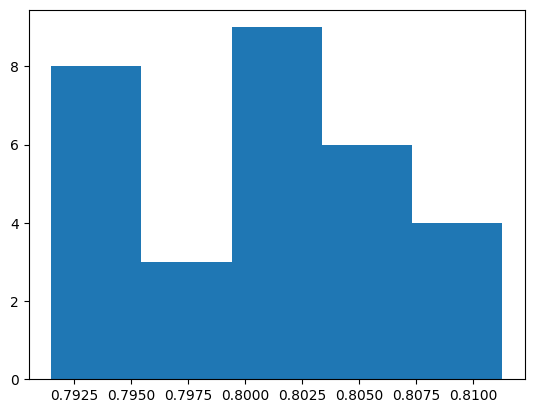

In [48]:
plt.hist(a, bins=5)

### Model testing 

#### Raw

In [33]:
# Raw 
tensor, tensor_test = data_tensor, data_tensor_test
pref=''
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for LogReg: 91.17% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for RF: 80.52% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: RF


100%|██████████| 30/30 [05:09<00:00, 10.33s/it]

Acc of RF: 80.04(0.55) %
[0.80517504 0.79299848 0.80365297 0.8021309  0.80821918 0.80060883
 0.79147641 0.79452055 0.79299848 0.79452055 0.80517504 0.80060883
 0.80821918 0.79299848 0.79908676 0.80060883 0.80517504 0.8021309
 0.80517504 0.80060883 0.80060883 0.79604262 0.79452055 0.80060883
 0.81126332 0.80060883 0.80365297 0.79604262 0.80974125 0.79147641]


In [34]:
# Raw  + tucker

tensor, tensor_test = tensor_tucker, tensor_tucker_test
pref='tucker'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tuckerLogReg: 91.48% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tuckerRF: 97.72% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tuckerRF


100%|██████████| 30/30 [05:28<00:00, 10.94s/it]

Acc of tuckerRF: 98.43(0.38) %
[0.97716895 0.98630137 0.98021309 0.98325723 0.98325723 0.98782344
 0.98021309 0.98021309 0.98782344 0.97869102 0.98325723 0.98782344
 0.98325723 0.9847793  0.98934551 0.98782344 0.9847793  0.9847793
 0.98782344 0.98173516 0.98325723 0.97716895 0.9847793  0.9847793
 0.98934551 0.98782344 0.99238965 0.97869102 0.9847793  0.9847793 ]


#### Start, End, Start-end

In [35]:
# Start
tensor, tensor_test = data_tensor_align_s, data_tensor_test_align_s
pref='s+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for s+LogReg: 89.35% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for s+RF: 82.34% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: s+RF


100%|██████████| 30/30 [05:14<00:00, 10.49s/it]

Acc of s+RF: 81.08(0.63) %
[0.82343988 0.80517504 0.81430746 0.8173516  0.82191781 0.81278539
 0.81126332 0.81126332 0.80974125 0.81126332 0.81887367 0.80060883
 0.80669711 0.81887367 0.80517504 0.80365297 0.80365297 0.80974125
 0.79908676 0.81582953 0.81430746 0.81278539 0.81582953 0.80821918
 0.81126332 0.80821918 0.81126332 0.8021309  0.80060883 0.8173516 ]


In [36]:
# Start + tucker
tensor, tensor_test = tensor_tucker_align_s, tensor_tucker_test_align_s
pref='tucker+s+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+s+LogReg: 90.56% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+s+RF: 98.33% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+s+RF


100%|██████████| 30/30 [05:22<00:00, 10.75s/it]

Acc of tucker+s+RF: 98.34(0.37) %
[0.98325723 0.98325723 0.98173516 0.97869102 0.98630137 0.98173516
 0.9847793  0.98173516 0.98325723 0.99086758 0.97869102 0.98782344
 0.98782344 0.98021309 0.97869102 0.97716895 0.98630137 0.97564688
 0.98630137 0.98173516 0.97869102 0.98173516 0.98630137 0.9847793
 0.98630137 0.98325723 0.98782344 0.98934551 0.98325723 0.9847793 ]


In [37]:
# End
tensor, tensor_test = data_tensor_align_e, data_tensor_test_align_e
pref='e+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for e+LogReg: 83.87% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for e+RF: 76.71% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: e+RF


100%|██████████| 30/30 [05:01<00:00, 10.03s/it]

Acc of e+RF: 76.98(0.83) %
[0.76712329 0.78234399 0.76560122 0.77473364 0.76407915 0.77321157
 0.76712329 0.76103501 0.75951294 0.75494673 0.76560122 0.78234399
 0.78082192 0.77321157 0.78995434 0.76255708 0.7716895  0.76712329
 0.76103501 0.77929985 0.76864536 0.77473364 0.76255708 0.77777778
 0.77016743 0.77625571 0.75951294 0.75951294 0.76560122 0.77473364]


In [38]:
# End + tucker
tensor, tensor_test = tensor_tucker_align_e, tensor_tucker_test_align_e
pref='tucker+e+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+e+LogReg: 84.17% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+e+RF: 96.50% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+e+RF


100%|██████████| 30/30 [05:05<00:00, 10.18s/it]

Acc of tucker+e+RF: 96.31(0.34) %
[0.96499239 0.96651446 0.96651446 0.9543379  0.95890411 0.96499239
 0.96347032 0.96499239 0.96803653 0.96347032 0.95890411 0.96194825
 0.96042618 0.96194825 0.96499239 0.96651446 0.96347032 0.96347032
 0.96042618 0.96651446 0.95738204 0.96347032 0.96042618 0.96499239
 0.9695586  0.96194825 0.95738204 0.96042618 0.96651446 0.96499239]


In [39]:
# SE
tensor, tensor_test = data_tensor_align_se, data_tensor_test_align_se
pref='se+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for se+LogReg: 93.30% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for se+RF: 80.97% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: se+RF


100%|██████████| 30/30 [05:13<00:00, 10.45s/it]

Acc of se+RF: 81.07(0.67) %
[0.80974125 0.80517504 0.80821918 0.81430746 0.81430746 0.8173516
 0.81278539 0.82191781 0.81278539 0.82648402 0.80821918 0.80365297
 0.80974125 0.81278539 0.8021309  0.81887367 0.80517504 0.81887367
 0.79452055 0.82191781 0.80517504 0.81430746 0.81126332 0.80821918
 0.80821918 0.80821918 0.80365297 0.80365297 0.80821918 0.81126332]


In [40]:
# SE + tucker
tensor, tensor_test = tensor_tucker_align_se, tensor_tucker_test_align_se
pref='tucker+se+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+se+LogReg: 93.46% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+se+RF: 99.24% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+se+RF


100%|██████████| 30/30 [05:22<00:00, 10.75s/it]

Acc of tucker+se+RF: 99.20(0.25) %
[0.99238965 0.99086758 0.99238965 0.99543379 0.99391172 0.98782344
 0.99391172 0.99391172 0.99391172 0.99238965 0.99238965 0.99238965
 0.99391172 0.98934551 0.99238965 0.9847793  0.99543379 0.98934551
 0.99238965 0.99391172 0.99543379 0.99543379 0.99086758 0.99238965
 0.98934551 0.99391172 0.98782344 0.99086758 0.99238965 0.98934551]


#### Augmentation 

In [184]:
# Aug_U
tensor, tensor_test = data_tensor_aug_u, data_tensor_test_aug_u
pref='aug_u+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for aug_u+LogReg: 84.47% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for aug_u+RF: 73.97% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: aug_u+RF


100%|██████████| 30/30 [05:00<00:00, 10.03s/it]

Acc of aug_u+RF: 73.59(0.74) %
[0.73972603 0.7412481  0.74885845 0.73211568 0.73059361 0.74277017
 0.73668189 0.72298326 0.74277017 0.73668189 0.74429224 0.73668189
 0.73211568 0.75038052 0.74581431 0.73820396 0.73363775 0.73059361
 0.73515982 0.71232877 0.73668189 0.72754947 0.73515982 0.73668189
 0.73820396 0.72907154 0.73363775 0.73972603 0.73515982 0.73211568]


In [185]:
# Aug_u + tucker
tensor, tensor_test = tensor_tucker_aug_u, tensor_tucker_test_aug_u
pref='tucker+aug_u+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+aug_u+LogReg: 68.80% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+aug_u+RF: 95.74% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+aug_u+RF


100%|██████████| 30/30 [05:15<00:00, 10.51s/it]

Acc of tucker+aug_u+RF: 94.47(0.73) %
[0.95738204 0.94216134 0.94977169 0.95129376 0.94063927 0.94368341
 0.95129376 0.94977169 0.94216134 0.94520548 0.93759513 0.94216134
 0.95281583 0.94216134 0.9391172  0.94824962 0.92085236 0.95281583
 0.94368341 0.94368341 0.93302892 0.94824962 0.95281583 0.94368341
 0.95585997 0.94216134 0.94977169 0.9391172  0.94063927 0.9391172 ]


In [186]:
# Aug_N
tensor, tensor_test = data_tensor_aug_n, data_tensor_test_aug_n
pref='aug_n+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for aug_n+LogReg: 80.52% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for aug_n+RF: 72.45% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: aug_n+RF


100%|██████████| 30/30 [04:58<00:00,  9.96s/it]

Acc of aug_n+RF: 72.14(0.54) %
[0.72450533 0.7260274  0.71385084 0.71689498 0.7260274  0.72450533
 0.71993912 0.71841705 0.72907154 0.72907154 0.71537291 0.72146119
 0.72298326 0.72298326 0.72146119 0.72450533 0.72298326 0.72298326
 0.72146119 0.71232877 0.72146119 0.71993912 0.71537291 0.70776256
 0.7260274  0.72146119 0.71689498 0.72146119 0.73515982 0.71993912]


In [187]:
# Aug_N + tucker
tensor, tensor_test = tensor_tucker_aug_n, tensor_tucker_test_aug_n
pref='tucker+aug_n+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+aug_n+LogReg: 70.62% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+aug_n+RF: 94.52% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+aug_n+RF


100%|██████████| 30/30 [05:20<00:00, 10.68s/it]

Acc of tucker+aug_n+RF: 93.92(0.51) %
[0.94520548 0.93150685 0.93759513 0.9391172  0.94216134 0.93759513
 0.93607306 0.92998478 0.93759513 0.93607306 0.94520548 0.94368341
 0.93607306 0.93455099 0.93455099 0.93302892 0.93759513 0.9391172
 0.94063927 0.93455099 0.93607306 0.94520548 0.9391172  0.94520548
 0.94824962 0.94520548 0.94216134 0.94216134 0.93150685 0.94977169]


In [53]:
# Aug_U_hard
tensor, tensor_test = data_tensor_aug_u_h, data_tensor_test_aug_u_h
pref='aug_u_h+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for aug_u_h+LogReg: 75.80% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for aug_u_h+RF: 61.49% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: aug_u_h+RF


100%|██████████| 30/30 [05:29<00:00, 10.99s/it]

Acc of aug_u_h+RF: 62.37(0.76) %
[0.61491629 0.63165906 0.64383562 0.62100457 0.6194825  0.62557078
 0.61035008 0.6194825  0.63013699 0.63318113 0.63165906 0.62404871
 0.6194825  0.62404871 0.61187215 0.62861492 0.62100457 0.62557078
 0.63318113 0.6194825  0.62404871 0.6194825  0.63165906 0.62100457
 0.62404871 0.61187215 0.62404871 0.6194825  0.6347032  0.61339422]


In [54]:
# Aug_u_hard + tucker
tensor, tensor_test = tensor_tucker_aug_u_h, tensor_tucker_test_aug_u_h
pref='tucker+aug_u_h+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+aug_u_h+LogReg: 34.86% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+aug_u_h+RF: 79.76% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+aug_u_h+RF


100%|██████████| 30/30 [05:42<00:00, 11.41s/it]

Acc of tucker+aug_u_h+RF: 78.99(1.67) %
[0.79756469 0.78082192 0.78538813 0.79756469 0.79299848 0.76864536
 0.78538813 0.79756469 0.77929985 0.77625571 0.80365297 0.79452055
 0.80821918 0.82039574 0.78386606 0.78538813 0.81430746 0.78082192
 0.78843227 0.78082192 0.77321157 0.76560122 0.80060883 0.79908676
 0.77625571 0.80517504 0.80365297 0.82952816 0.76864536 0.75342466]


In [55]:
# Aug_N_hard
tensor, tensor_test = data_tensor_aug_n_h, data_tensor_test_aug_n_h
pref='aug_n_h+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for aug_n_h+LogReg: 77.17% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for aug_n_h+RF: 66.51% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: aug_n_h+RF


100%|██████████| 30/30 [05:33<00:00, 11.11s/it]

Acc of aug_n_h+RF: 64.61(0.84) %
[0.6651446  0.63013699 0.64687976 0.65601218 0.6499239  0.64231355
 0.64535769 0.63926941 0.64535769 0.64079148 0.64687976 0.63622527
 0.64231355 0.64383562 0.64535769 0.64535769 0.65296804 0.65296804
 0.64231355 0.65601218 0.65449011 0.63013699 0.63926941 0.64535769
 0.65144597 0.63165906 0.65144597 0.64687976 0.64383562 0.66362253]


In [56]:
# Aug_N_hard + tucker
tensor, tensor_test = tensor_tucker_aug_n_h, tensor_tucker_test_aug_n_h
pref='tucker+aug_n_h+'
with parallel_backend("multiprocessing"):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        test_LogReg(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  max_iter=1000, n_jobs=50, do_scaler=True, conf_matrices=False, test_trials=1)
        test_RandomForest(tensor, tensor_test, labels_list, labels_list_test, pref=pref, exp_cofig=exp_cofig,  n_estimators=300, n_jobs=50, do_scaler=False, conf_matrices=False, test_trials=30)

Test accuracy for tucker+aug_n_h+LogReg: 39.57% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
Test accuracy for tucker+aug_n_h+RF: 80.97% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]
For model: tucker+aug_n_h+RF


100%|██████████| 30/30 [05:37<00:00, 11.25s/it]

Acc of tucker+aug_n_h+RF: 80.54(1.30) %
[0.80974125 0.78843227 0.80974125 0.81126332 0.79908676 0.80974125
 0.82496195 0.78995434 0.81887367 0.80821918 0.79756469 0.80821918
 0.8325723  0.78538813 0.80669711 0.79604262 0.79908676 0.77625571
 0.80821918 0.81430746 0.81278539 0.81278539 0.8173516  0.82191781
 0.81582953 0.81278539 0.78995434 0.79147641 0.80821918 0.78538813]


#### Delta comparison - not a proper idea 

In [ ]:
a1 = '''0.80517504 0.79299848 0.80365297 0.8021309  0.80821918 0.80060883
 0.79147641 0.79452055 0.79299848 0.79452055 0.80517504 0.80060883
 0.80821918 0.79299848 0.79908676 0.80060883 0.80517504 0.8021309
 0.80517504 0.80060883 0.80060883 0.79604262 0.79452055 0.80060883
 0.81126332 0.80060883 0.80365297 0.79604262 0.80974125 0.79147641'''
a1 = np.asarray([float(el) for el in a1.split()])

b1 = '''0.97716895 0.98630137 0.98021309 0.98325723 0.98325723 0.98782344
 0.98021309 0.98021309 0.98782344 0.97869102 0.98325723 0.98782344
 0.98325723 0.9847793  0.98934551 0.98782344 0.9847793  0.9847793
 0.98782344 0.98173516 0.98325723 0.97716895 0.9847793  0.9847793
 0.98934551 0.98782344 0.99238965 0.97869102 0.9847793  0.9847793'''
b1 = np.asarray([float(el) for el in b1.split()])


In [ ]:
# Start
a2 = '''0.82343988 0.80517504 0.81430746 0.8173516  0.82191781 0.81278539
 0.81126332 0.81126332 0.80974125 0.81126332 0.81887367 0.80060883
 0.80669711 0.81887367 0.80517504 0.80365297 0.80365297 0.80974125
 0.79908676 0.81582953 0.81430746 0.81278539 0.81582953 0.80821918
 0.81126332 0.80821918 0.81126332 0.8021309  0.80060883 0.8173516'''
a2 = np.asarray([float(el) for el in a2.split()])

b2 = '''0.98325723 0.98325723 0.6895 0.98630137 0.97564688
 0.98630137 0.98173516 0.97869102 0.98173516 0.98630137 0.9847793
 0.98630137 0.98325723 0.98782344 0.98934551 0.98325723 0.9847798173516 0.97869102 0.98630137 0.98173516
 0.9847793  0.98173516 0.98325723 0.99086758 0.97869102 0.98782344
 0.98782344 0.98021309 0.97869102 0.977193'''
b2 = np.asarray([float(el) for el in b2.split()])

data_name = 'Start'


In [ ]:
# End
a2 = '''0.76712329 0.78234399 0.76560122 0.77473364 0.76407915 0.77321157
 0.76712329 0.76103501 0.75951294 0.75494673 0.76560122 0.78234399
 0.78082192 0.77321157 0.78995434 0.76255708 0.7716895  0.76712329
 0.76103501 0.77929985 0.76864536 0.77473364 0.76255708 0.77777778
 0.77016743 0.77625571 0.75951294 0.75951294 0.76560122 0.77473364'''
a2 = np.asarray([float(el) for el in a2.split()])

b2 = '''0.96499239 0.96651446 0.96651446 0.9543379  0.95890411 0.96499239
 0.96347032 0.96499239 0.96803653 0.96347032 0.95890411 0.96194825
 0.96042618 0.96194825 0.96499239 0.96651446 0.96347032 0.96347032
 0.96042618 0.96651446 0.95738204 0.96347032 0.96042618 0.96499239
 0.9695586  0.96194825 0.95738204 0.96042618 0.96651446 0.96499239'''
b2 = np.asarray([float(el) for el in b2.split()])

data_name = 'End'

In [ ]:
# SE
a2 = '''0.80974125 0.80517504 0.80821918 0.81430746 0.81430746 0.8173516
 0.81278539 0.82191781 0.81278539 0.82648402 0.80821918 0.80365297
 0.80974125 0.81278539 0.8021309  0.81887367 0.80517504 0.81887367
 0.79452055 0.82191781 0.80517504 0.81430746 0.81126332 0.80821918
 0.80821918 0.80821918 0.80365297 0.80365297 0.80821918 0.81126332'''
a2 = np.asarray([float(el) for el in a2.split()])

b2 = '''0.99238965 0.99086758 0.99238965 0.99543379 0.99391172 0.98782344
 0.99391172 0.99391172 0.99391172 0.99238965 0.99238965 0.99238965
 0.99391172 0.98934551 0.99238965 0.9847793  0.99543379 0.98934551
 0.99238965 0.99391172 0.99543379 0.99543379 0.99086758 0.99238965
 0.98934551 0.99391172 0.98782344 0.99086758 0.99238965 0.98934551'''
b2 = np.asarray([float(el) for el in b2.split()])

data_name = 'SE'

In [ ]:
from scipy.stats import ttest_ind

da = a2 - a1
db = b2 - b1
t, p = ttest_ind(da, db)
print(data_name)
print(f"p={p :0.4f}, t={t :0.4f}")
print(f"{p :0.4f}")
print(f"{t :0.4f}")

SE
p=0.2178, t=1.2460
0.2178
1.2460


## Original

In [204]:
tensor = data_tensor
tensor_test = data_tensor_test


# tensor = data_tensor_
# tensor_test = data_tensor_test_


# tensor = data_tensor__
# tensor_test = data_tensor_test__

pref = ''

#### LogReg

In [95]:
model = LogisticRegression(max_iter=1000, n_jobs=32)
model_name = pref + 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


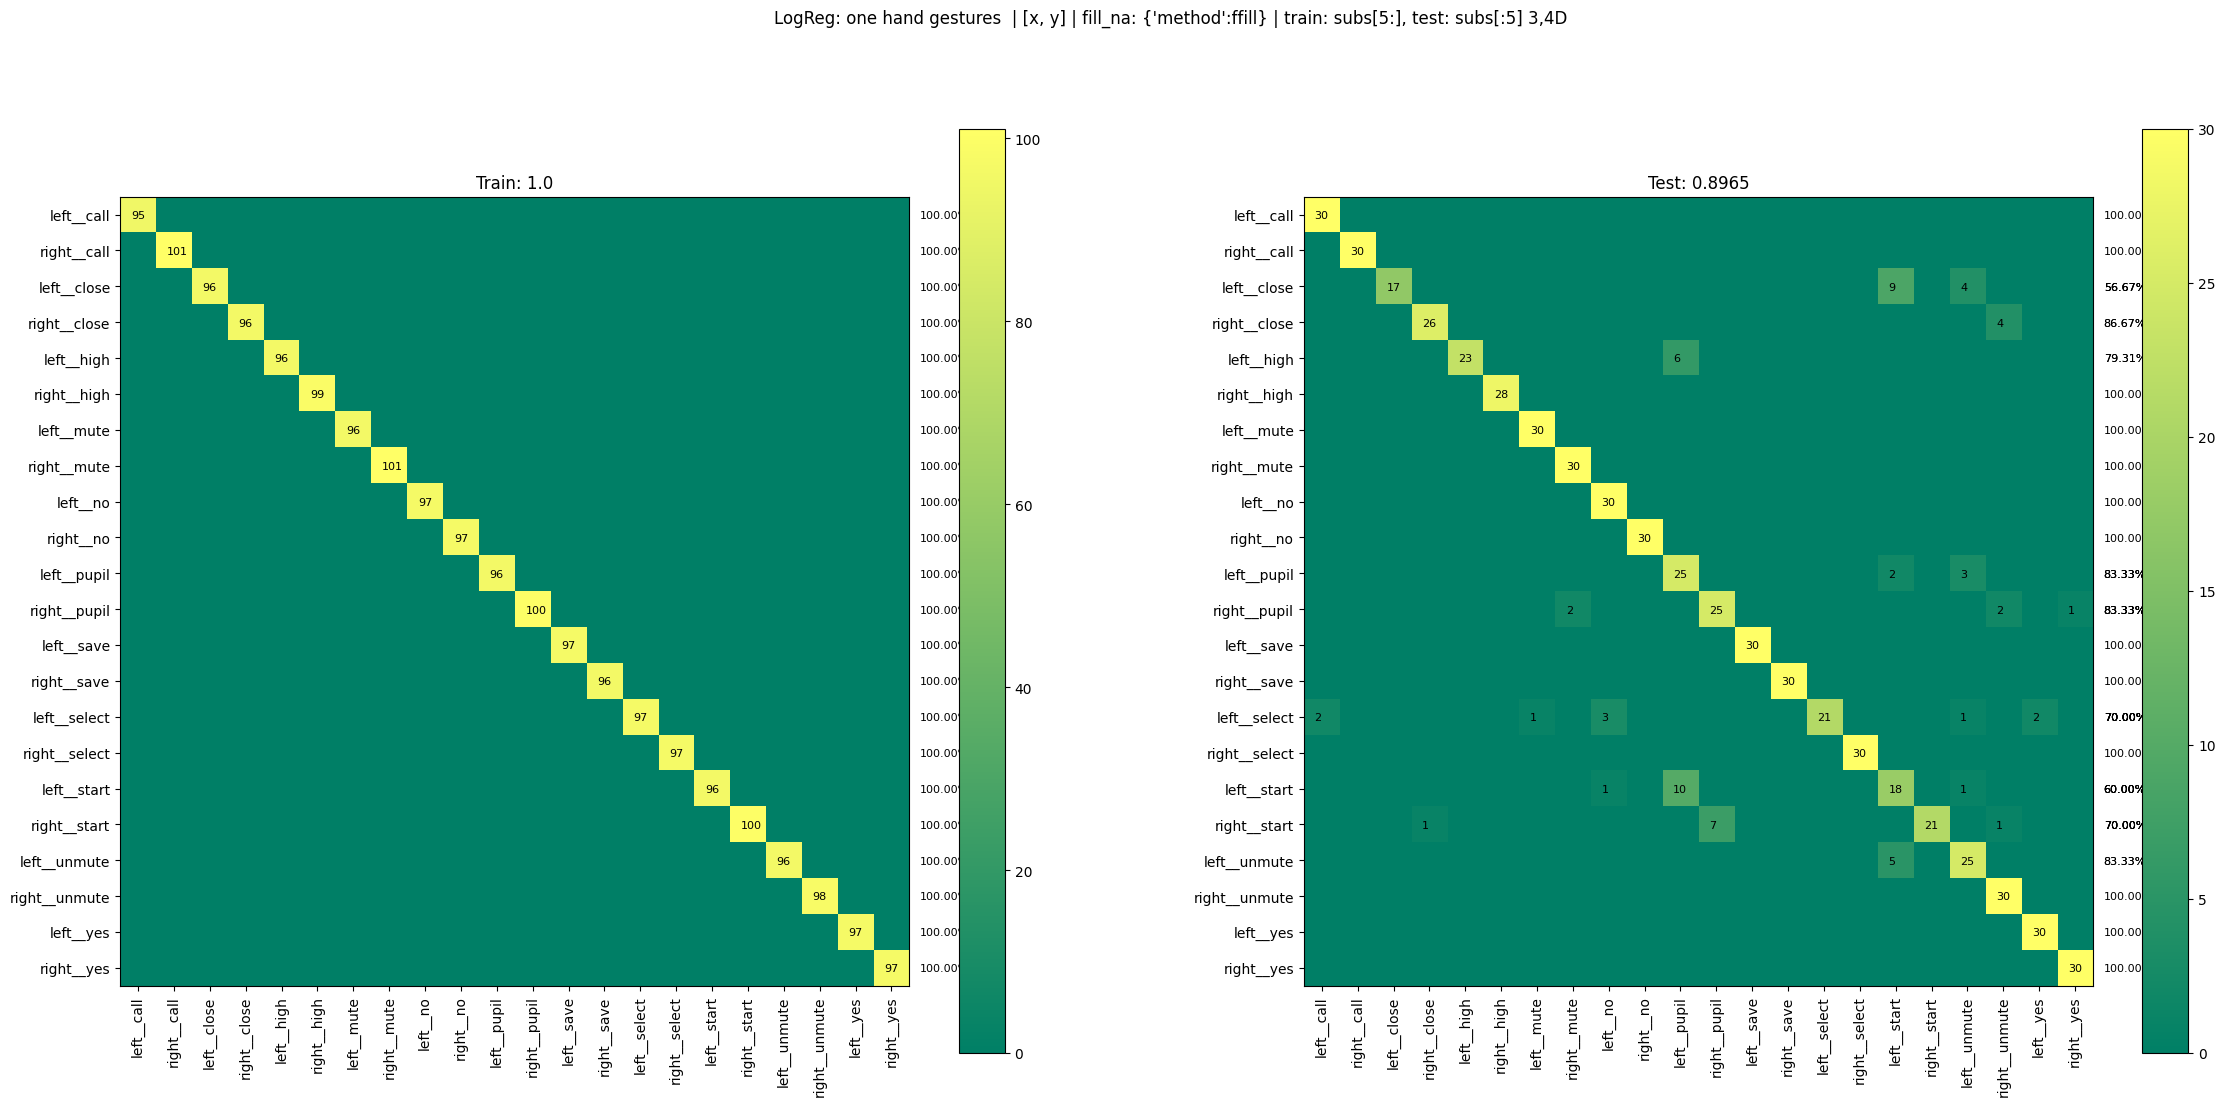

In [96]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [89]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, True, n_trials=1)

For model: LogReg


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

Acc of LogReg: 67.27(0.00) %


array([0.67272727])

##### Backup code

In [225]:
# model = LogisticRegression(max_iter=200)
# model_name = 'LogReg'
# X_train, y_train = make_X_y(tensor, labels_list)
# X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# model.fit(X_train, y_train)

In [70]:
# label = model.predict(X_test)
# acc = accuracy_score(y_test, label )
# print(acc)
# plot_confusion_matrix(y_test, label, label_dict)
# plt.title('Confusion Matrix: Test data')

#### RandomForest

In [167]:
from sklearn.tree import DecisionTreeClassifier

In [205]:
model = RandomForestClassifier(n_estimators=300)
# model = DecisionTreeClassifier(max_depth=30, min_samples_split=5, min_samples_leaf=5 )
# model_name = pref + 'DT'
model_name = pref + 'RF'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

Test accuracy for RF: 79.60% 	[one hand gestures  | [x, y] | fill_na: {'method':ffill} | train: subs[5:], test: subs[:5] alignment test]


0.7960426179604262

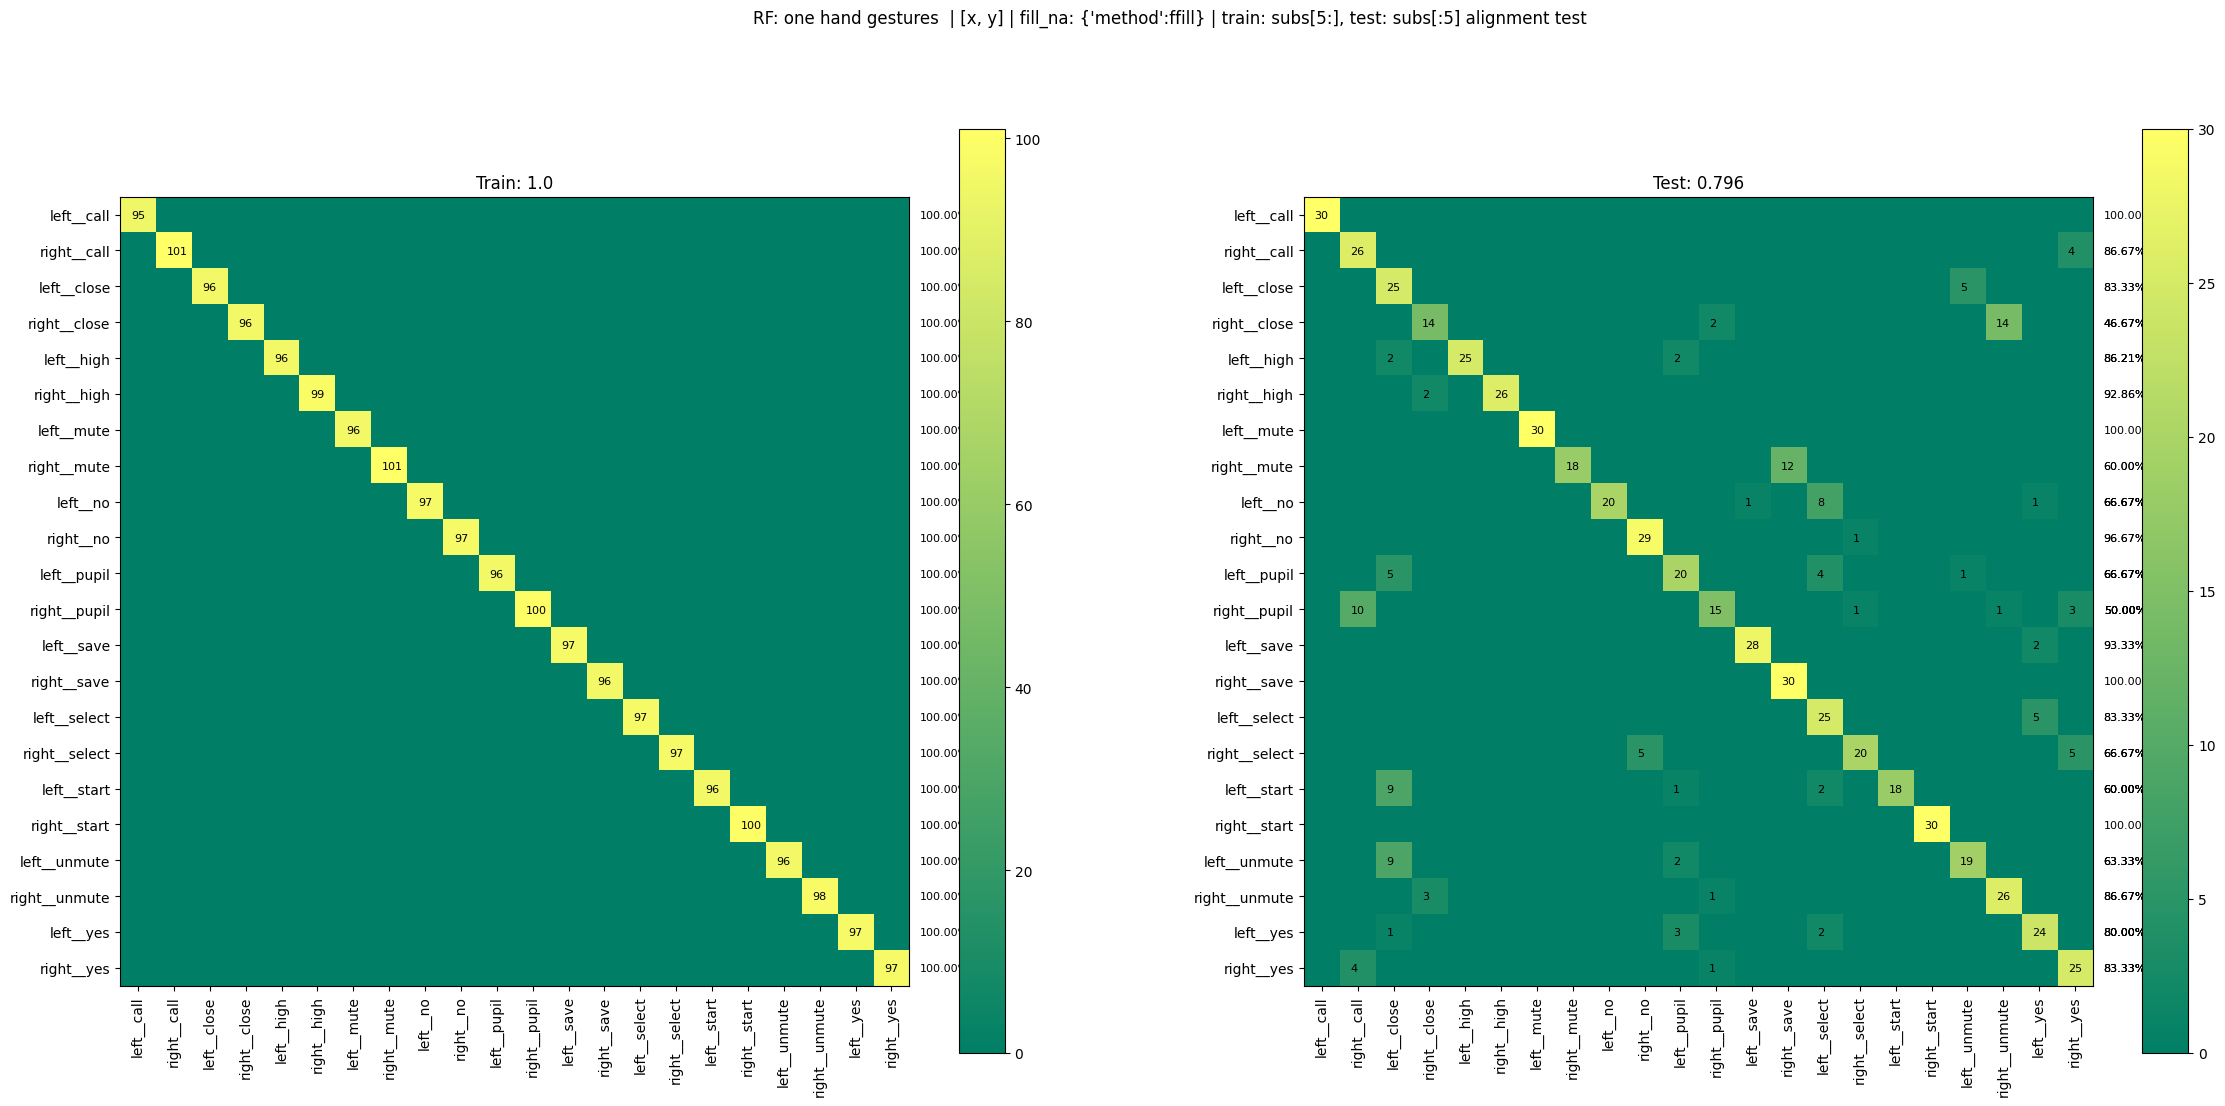

In [206]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [207]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, False, n_trials=20)

For model: RF


 30%|███       | 6/20 [05:07<11:57, 51.25s/it]


KeyboardInterrupt: 

### other

#### XGBoost 

In [41]:
model = xgb.XGBClassifier(n_estimators=200)
model_name = pref + 'XGB'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



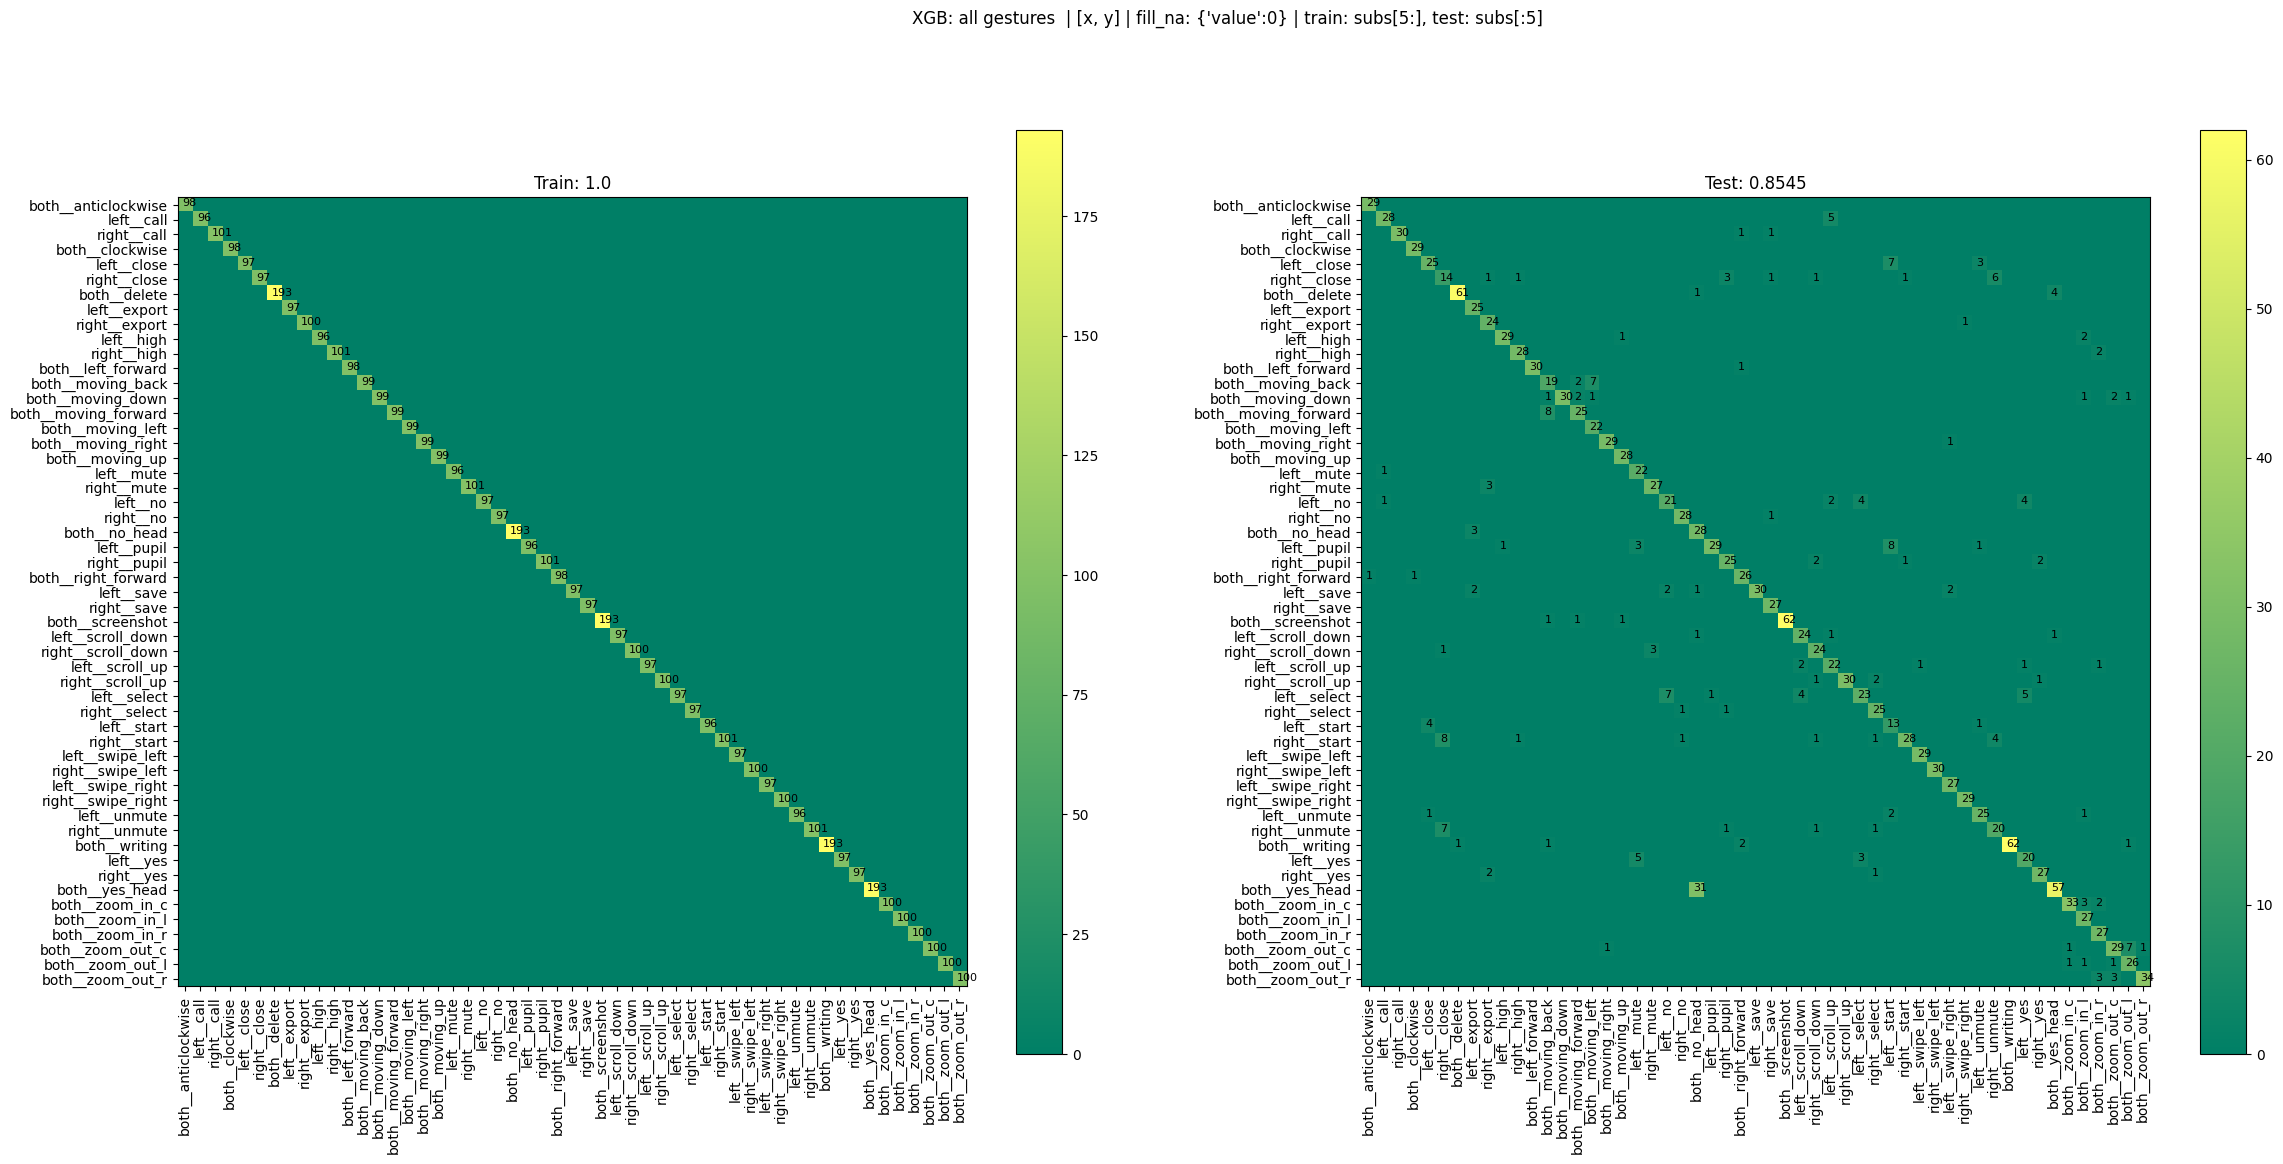

In [42]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

#### SVM

In [45]:
model = SVC(kernel='linear')
model_name = pref + 'SVC'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

SVC(kernel='linear')

In [46]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

2
2



#### STM

In [58]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = pref + 'STM'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

maxIter  2
ovr 1.0 1.0 2 0.01 l2 True 0.01 squared_hinge 100000
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2
1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2 / 2


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


STMM(maxIter=2, tol=0.01, tolSTM=0.01)

In [59]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

2
2



#### KNN

In [73]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = pref + 'KNN'

model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test,
                                                                   labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

KNeighborsClassifier(n_neighbors=8)

In [74]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

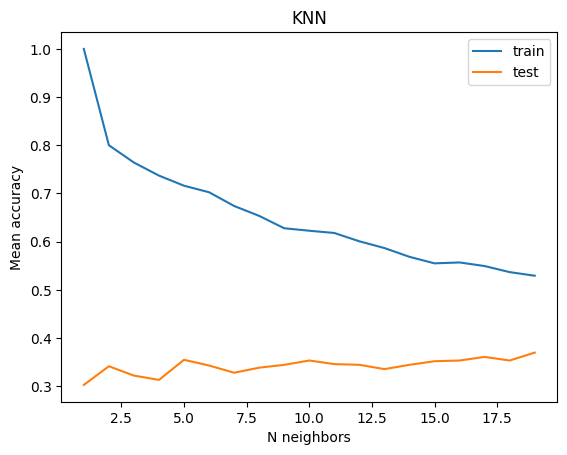

In [306]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

## After Tucker

In [97]:
# tensor = tensor_tucker_tn
# tensor_test = tensor_tucker_test_tn
tensor = tensor_tucker_tn_
tensor_test = tensor_tucker_test_tn_
pref = 'Tucker_tn+'

# tensor = tensor_tucker
# tensor_test = tensor_tucker_test
# pref = 'Tucker+'

#### LogReg

In [98]:
model = LogisticRegression(max_iter=200)
model_name = pref + 'LogReg'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list,
                                                                   labels_list_test, do_scaler=True)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)

In [99]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [57]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, True, n_trials=1)

For model: Tucker_tn+LogReg


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

Acc of Tucker_tn+LogReg: 91.48(0.00) %


array([0.91476408])

#### features

In [59]:
features.shape

(22, 16080)

<BarContainer object of 31892 artists>

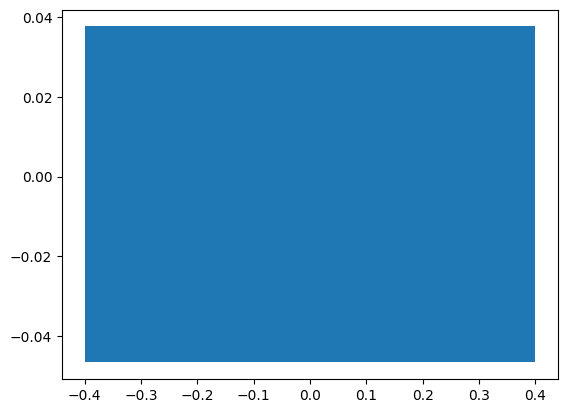

In [162]:
ii = 0
features = model.coef_[ii]
plt.bar(np.arange(features[ii].size), features)

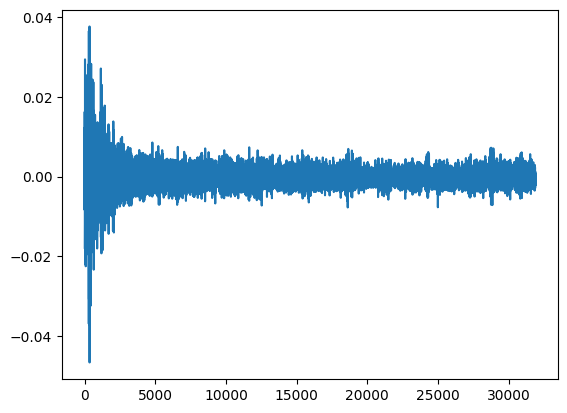

In [163]:
plt.plot(features)

#### Random Forest

In [100]:
model = RandomForestClassifier(n_estimators=200)
model_name = pref + 'RF'
model, model_name, X_train, X_test, y_train, y_test  = train_model((model, model_name), tensor, tensor_test, labels_list, labels_list_test, do_scaler=False)
# check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig)


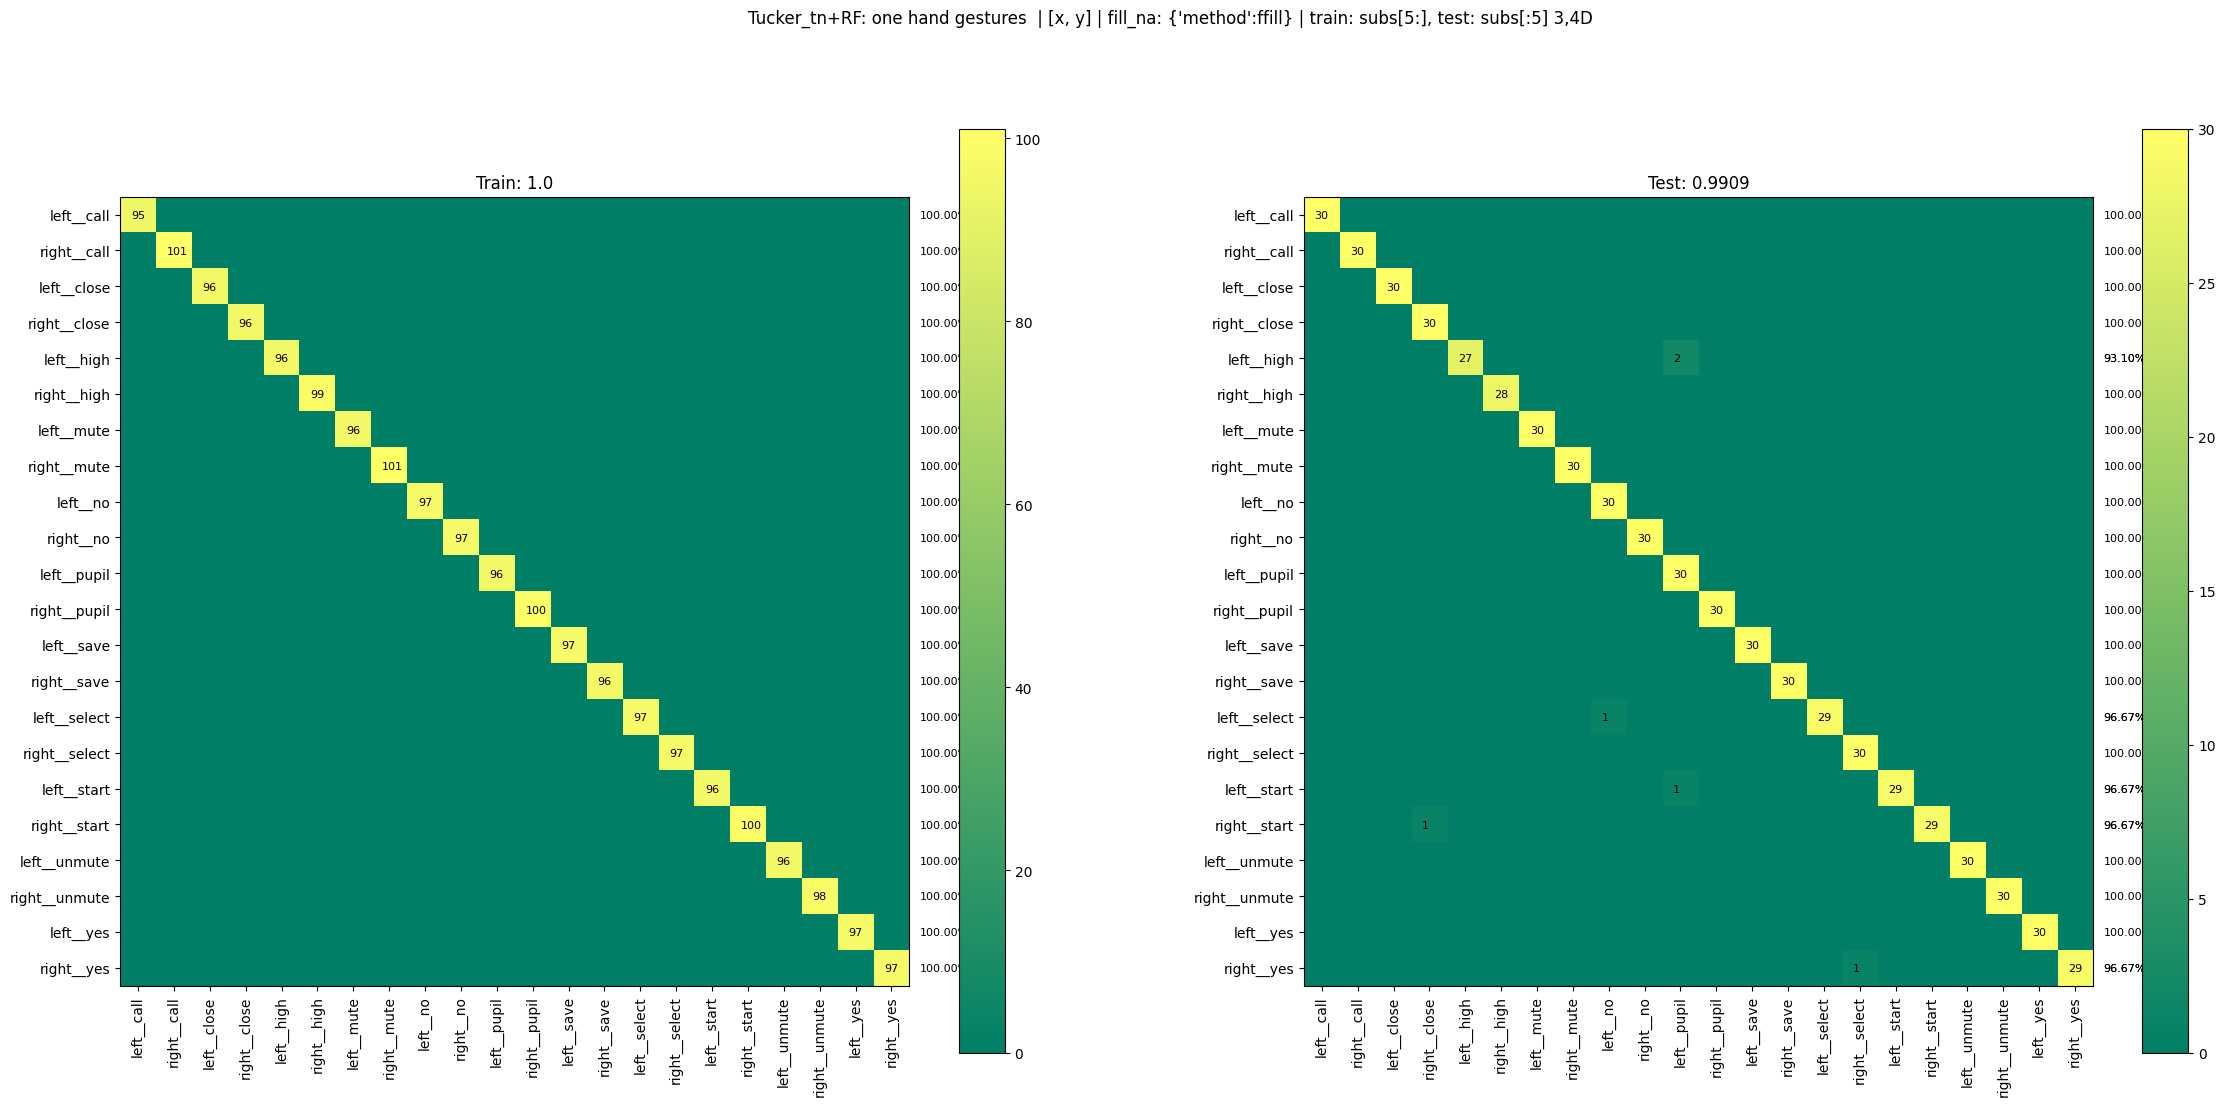

In [101]:
check_model(model, model_name,  X_train, X_test, y_train, y_test, exp_cofig, label_dict)

In [102]:
test_accuracy((model, model_name), tensor, tensor_test, labels_list, labels_list_test, False, n_trials=20, verbose=1)

For model: Tucker_tn+RF


100%|██████████| 20/20 [13:09<00:00, 39.50s/it]

Acc of Tucker_tn+RF: 99.05(0.28) %


array([0.99086758, 0.99543379, 0.99238965, 0.98782344, 0.98782344,
       0.98934551, 0.99391172, 0.99086758, 0.99238965, 0.98782344,
       0.98782344, 0.98782344, 0.98630137, 0.99695586, 0.99086758,
       0.99086758, 0.98934551, 0.98782344, 0.99391172, 0.98934551])

#### features

In [168]:
# ii = 0
features = model.feature_importances_
plt.plot(features)
# plt.bar(np.arange(features[ii].size), features)

In [167]:
features.shape

(31892,)

### other

#### XGBoost

In [52]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6)

model_name = 'Tucker + XGB'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

2
2



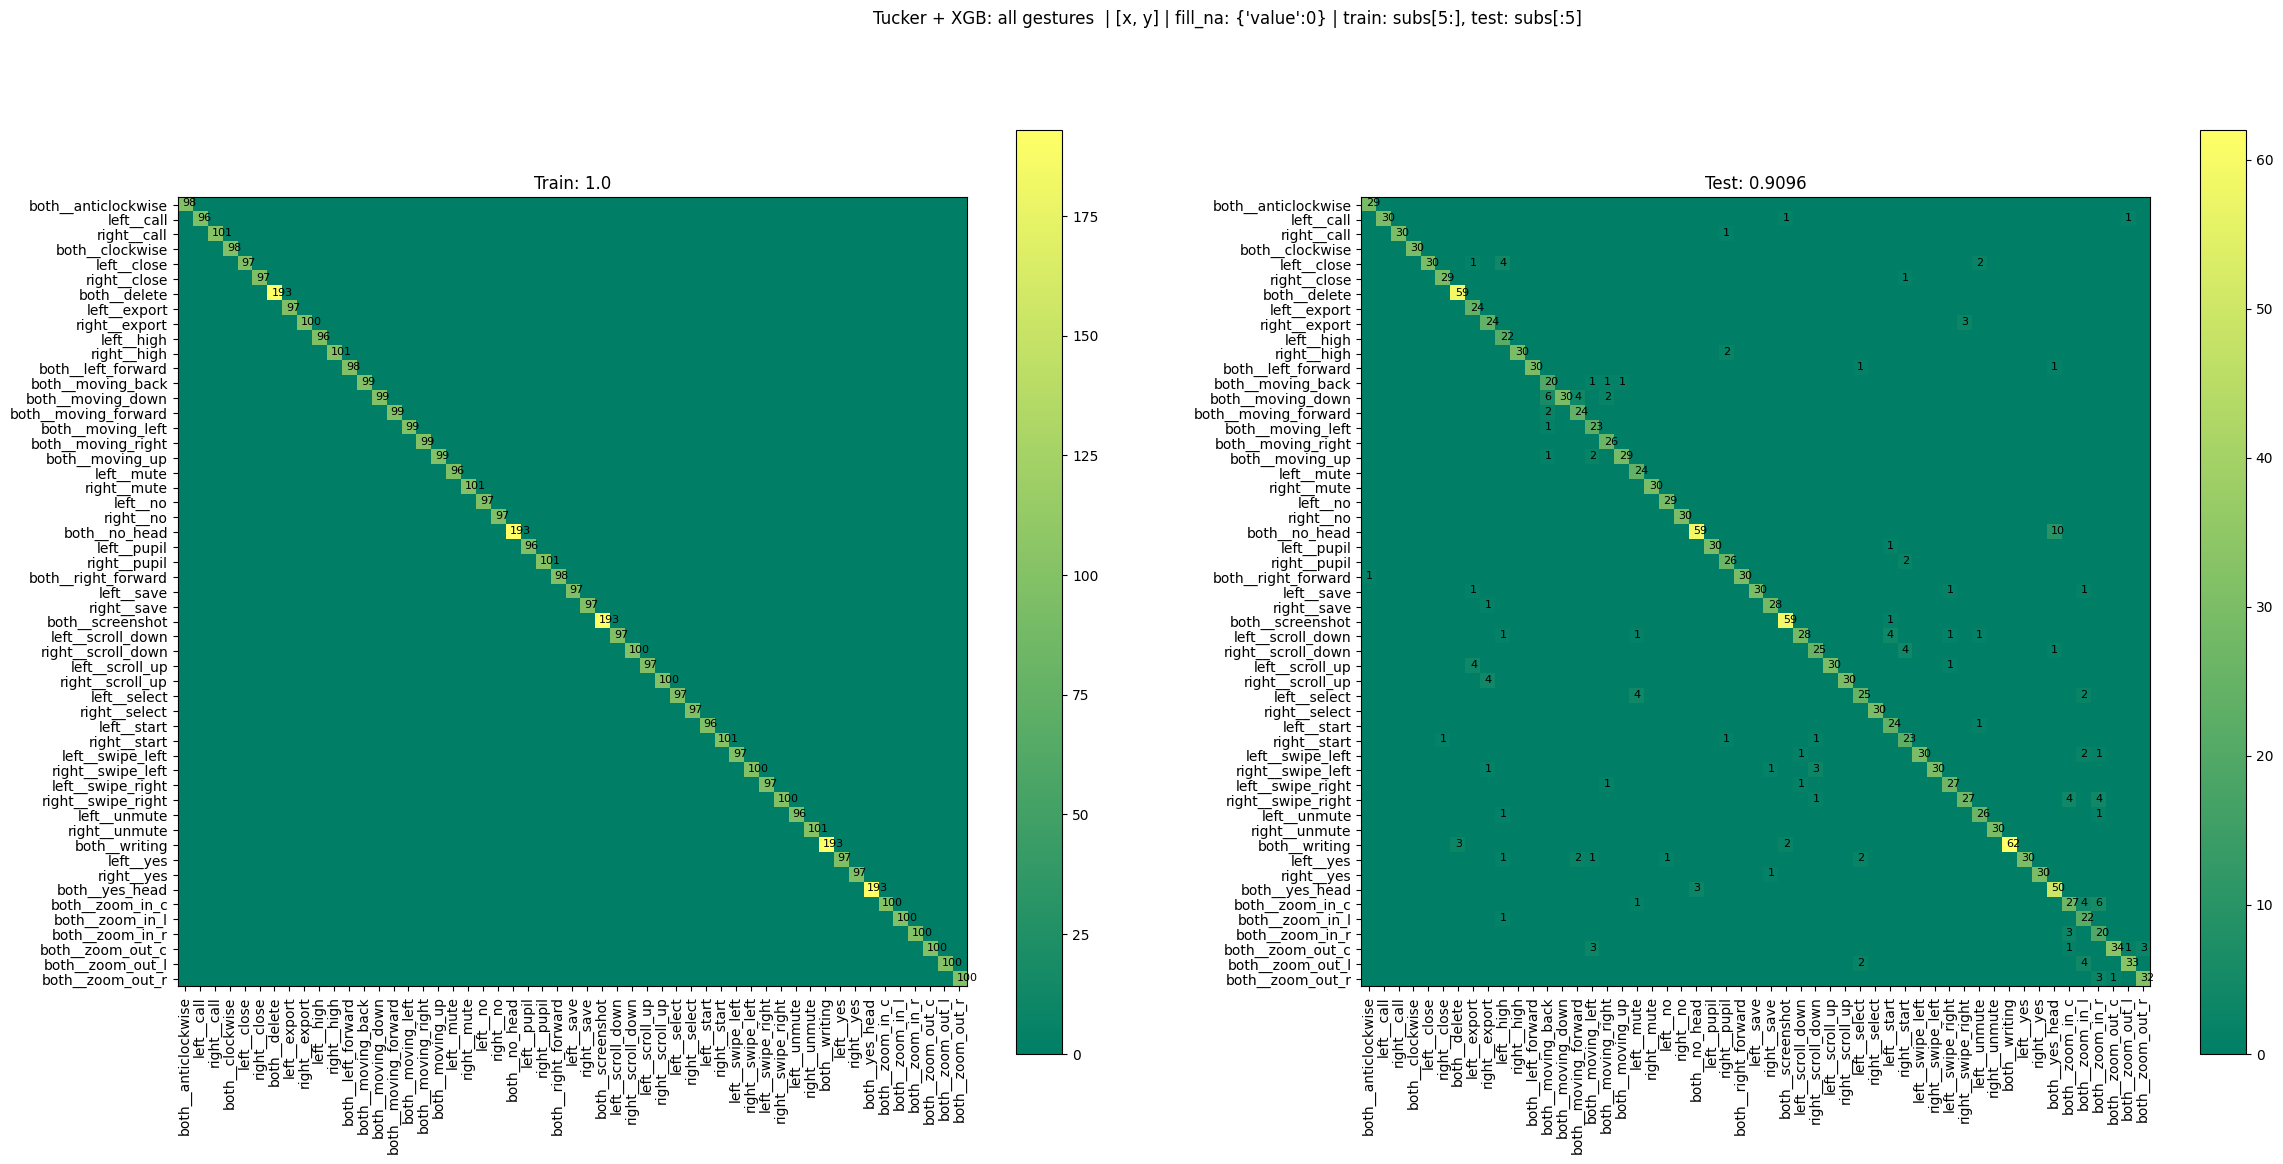

In [53]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### SVM

In [62]:
model = SVC(C=1, kernel='linear')
model_name = 'Tucker + SVC'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

2
2



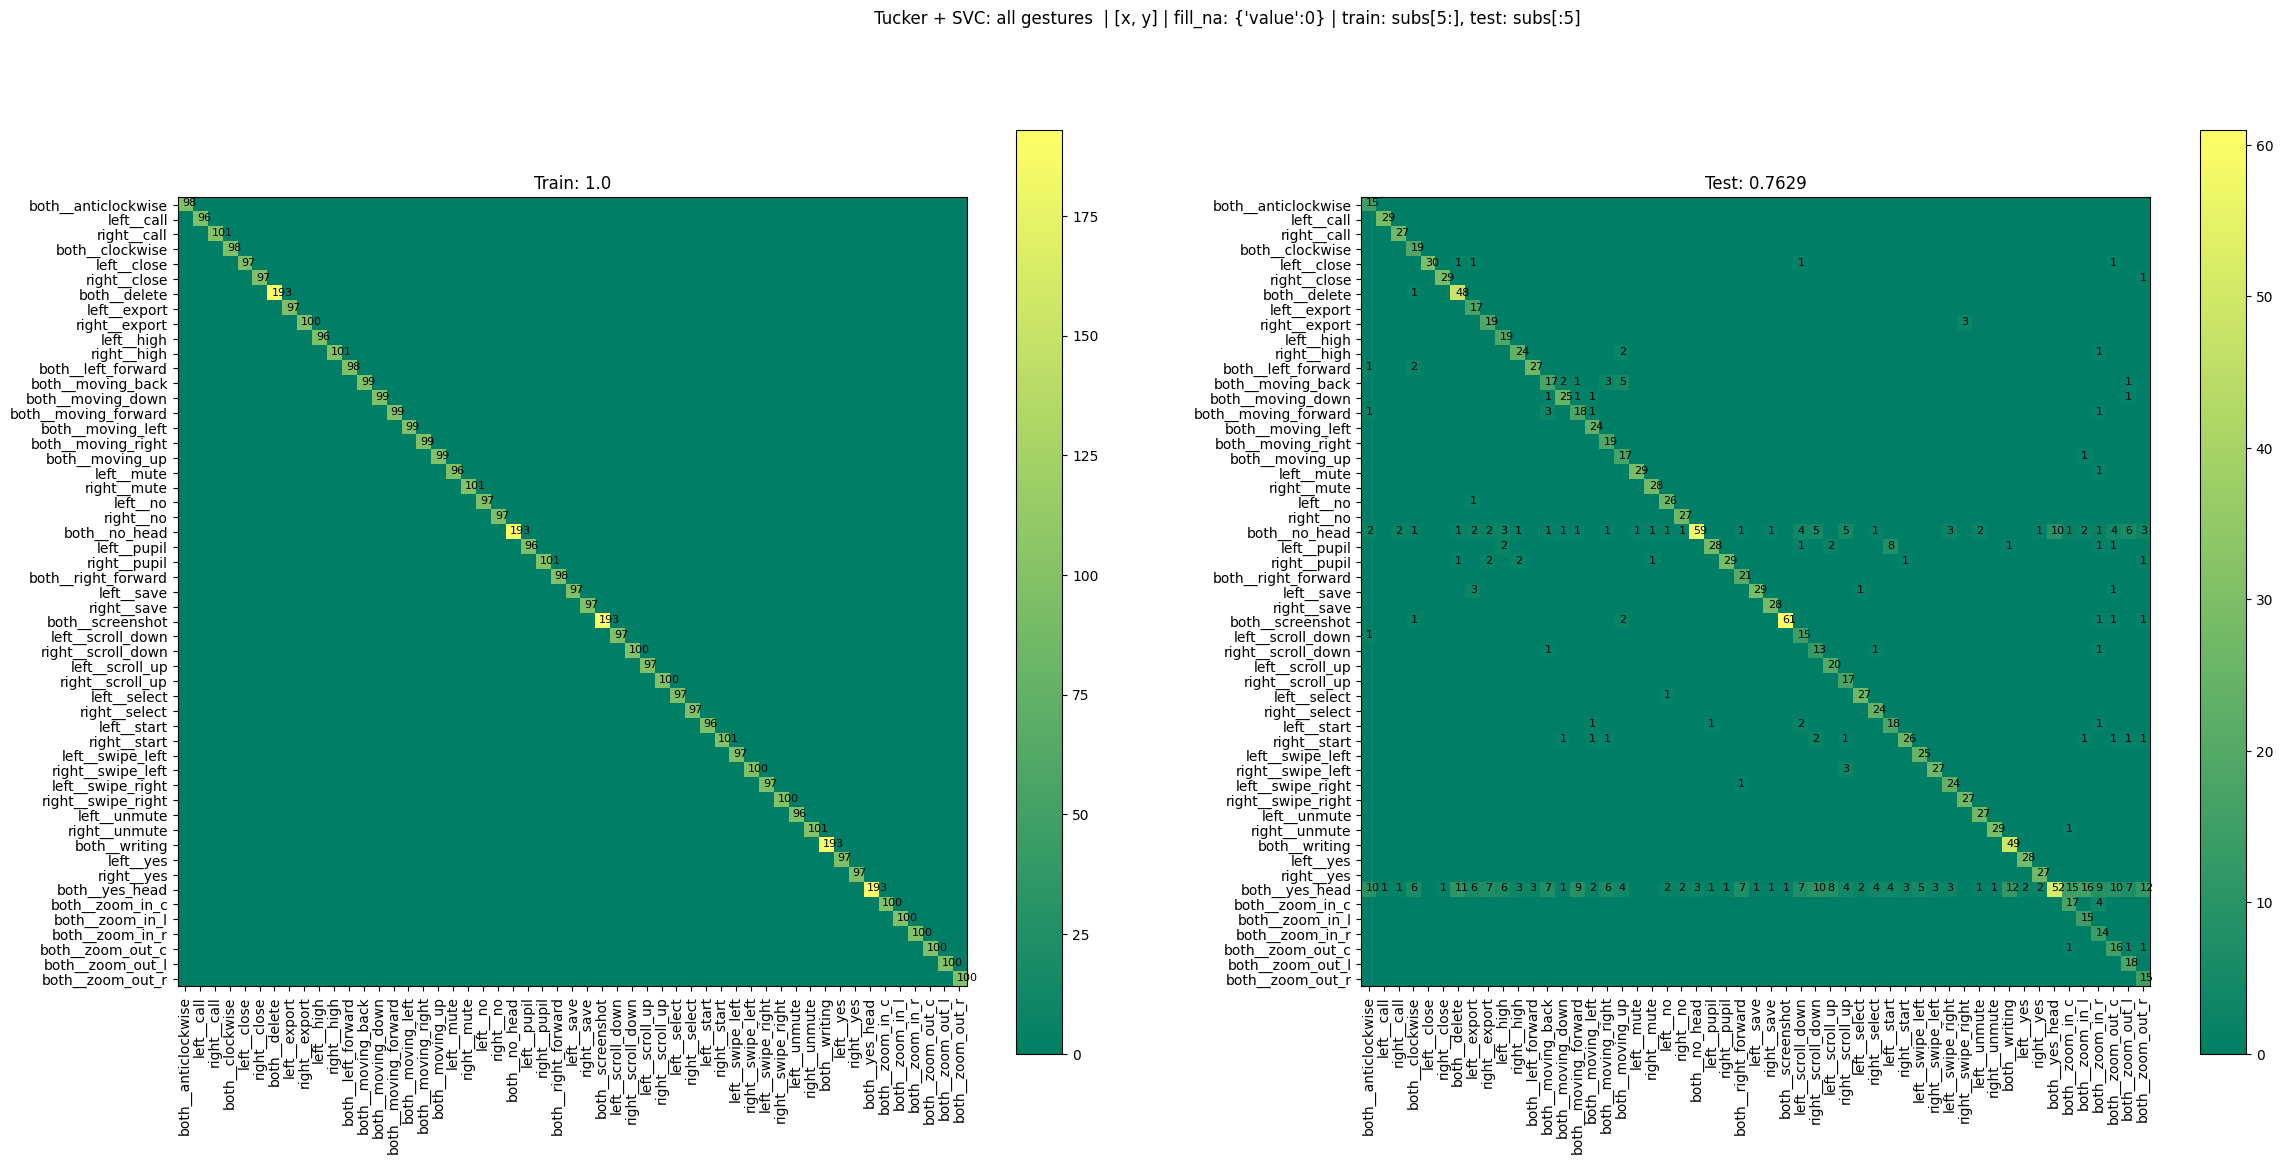

In [63]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### STM

In [ ]:
model = pystmm.classifier.STMM(maxIter=2, tolSTM=1e-2, tol=1e-2)
model_name = 'Tucker + STMM'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = tensor_tucker
X_test = tensor_test

model.fit(X_train, y_train)


2
2



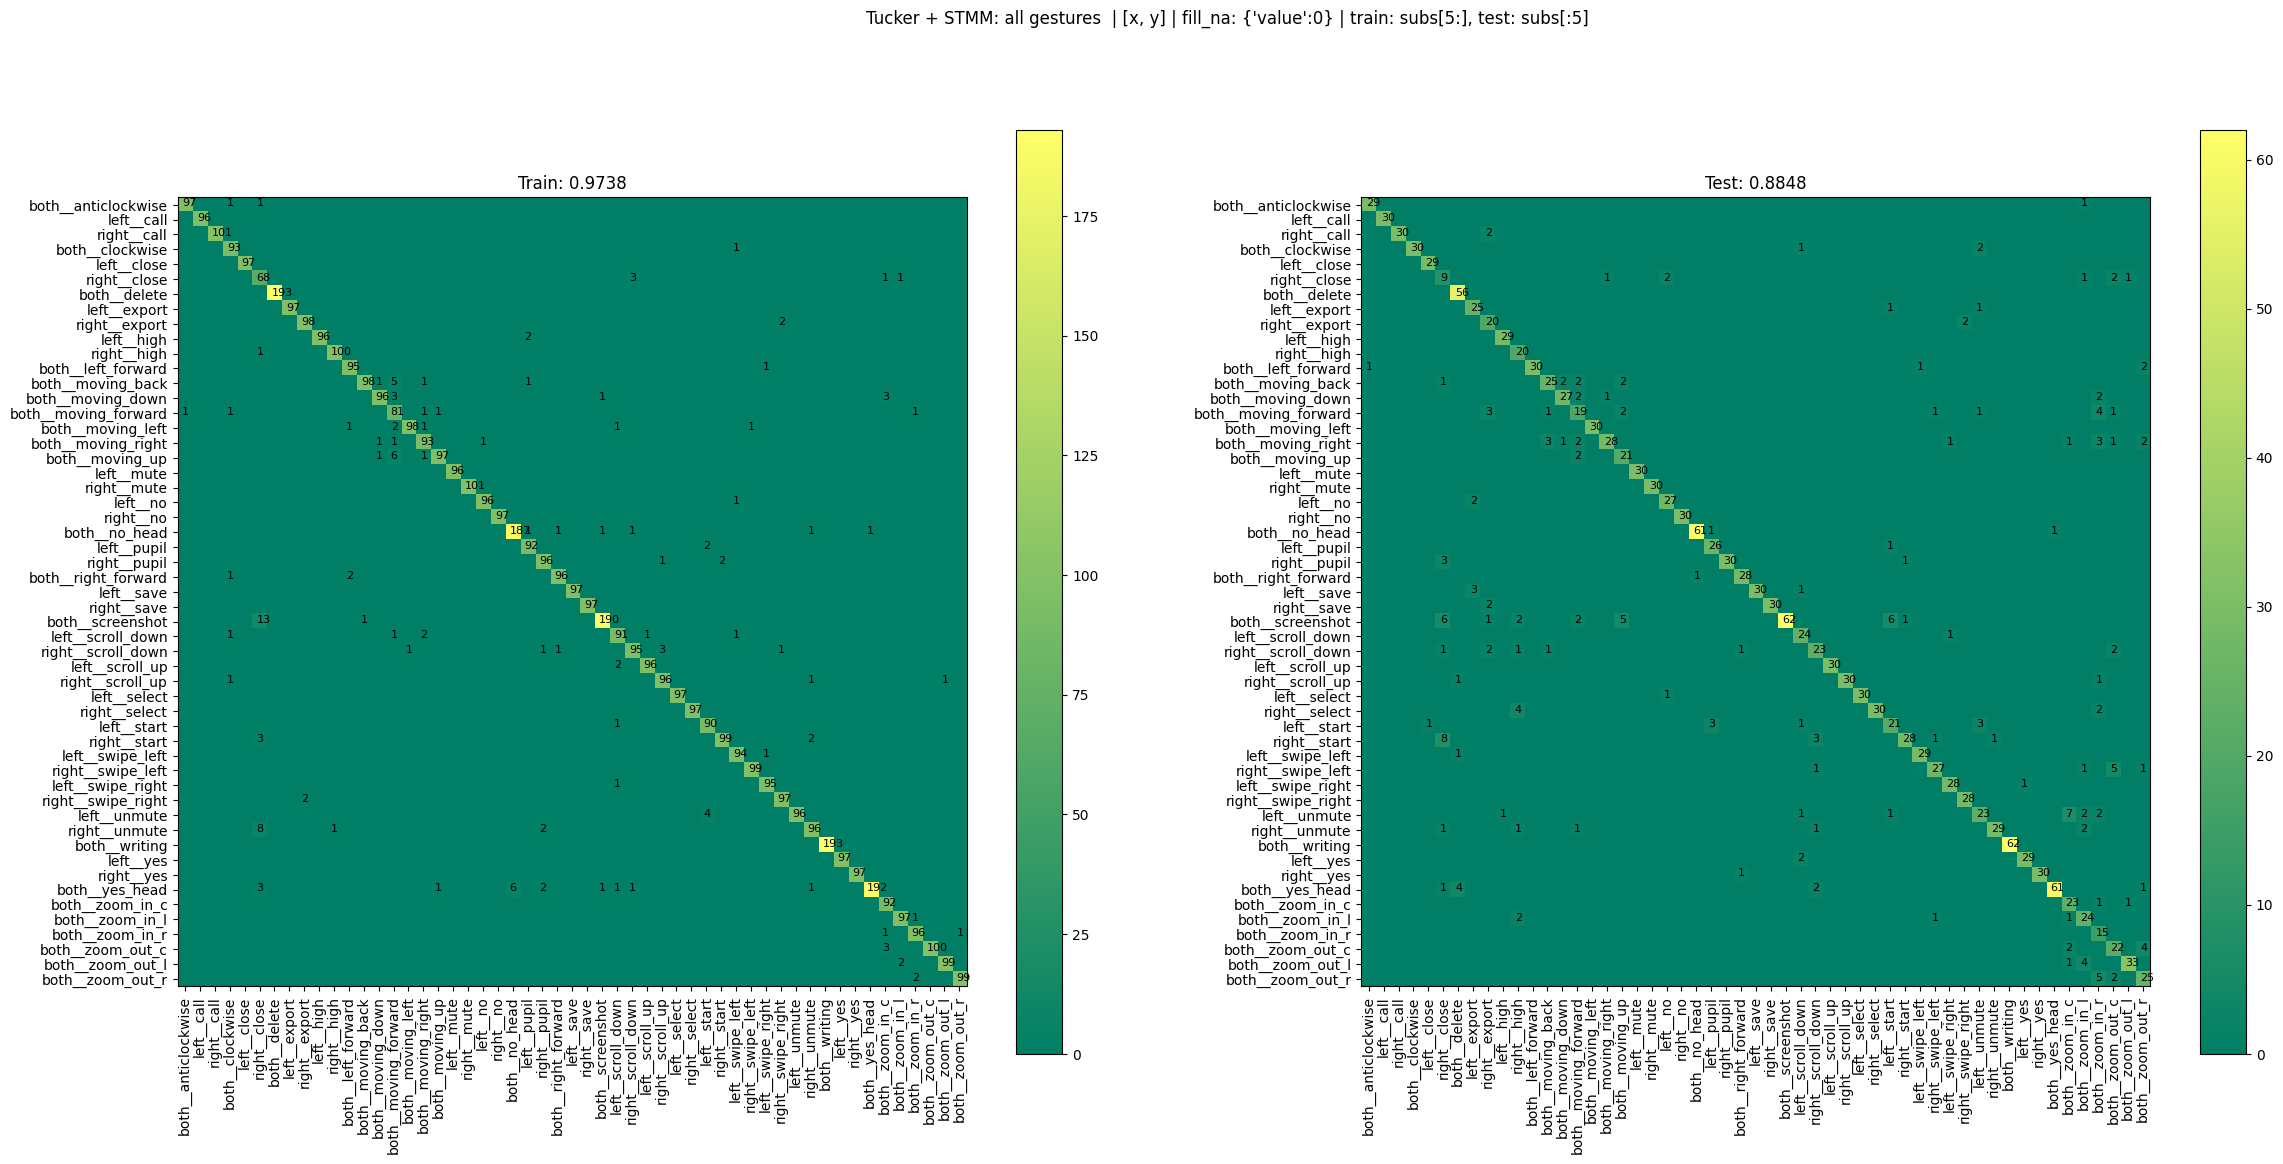

In [69]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name + ": "+ exp_cofig)
print()

#### KNN

In [60]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [61]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

2
2



In [33]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  